In [1]:
# en = args.encoder_layers
# de= args.decoder_layers
# random.seed(3000)
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels
import nibabel as nib
import tqdm
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import neurite as ne
import voxelmorph as vxm
from utils import *
import pathlib
import surfa as sf


mgh = pathlib.Path('fetus_label_map')
mgh_files = list(mgh.glob('*.nii.gz'))
label_maps = [np.uint8(sf.load_volume(str(file_path)).resize([1,1,1],method='nearest').reshape([192,192,192]).data) for file_path in mgh_files]


labels = np.unique(label_maps)
in_shape = label_maps[0].shape



num_labels=8
# labels_in = range(max(labels) + num_labels + 1)
labels_in = np.unique(label_maps) # change this for feta

# feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_3d')
# feta_files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
# feta = pathlib.Path('feta_scaled')
# feta_files = list(feta.glob('*.nii.gz'))
feta = pathlib.Path('feta_resized_192')
feta_files = list(feta.glob('*.nii.gz'))
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
# feta_label_maps = [np.uint8(sf.load_volume(str(f)).resize([1,1,1],method='nearest').reshape([256,256,256]).data) for f in feta_files]


feta_label_maps = [np.uint8(sf.load_volume(str(f)).resize([1,1,1],method='nearest').reshape([192,192,192]).data) for f in feta_files]
labels = np.unique(feta_label_maps)
# feta_label_maps = [np.uint8(f.dataobj) for f in map(nib.load, feta_files)]
print(len(feta_label_maps))
print(feta_label_maps[0].shape)


2024-03-29 13:50:06.972189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/space/bal_004/users/jd1677/singularity-images/tensorflow_2.13.0-gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


40
(192, 192, 192)


# Build New Training Data

(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
a [ 0  1  2  3  4  5  6  7  8  9 10 13 14 17 18 22 23]


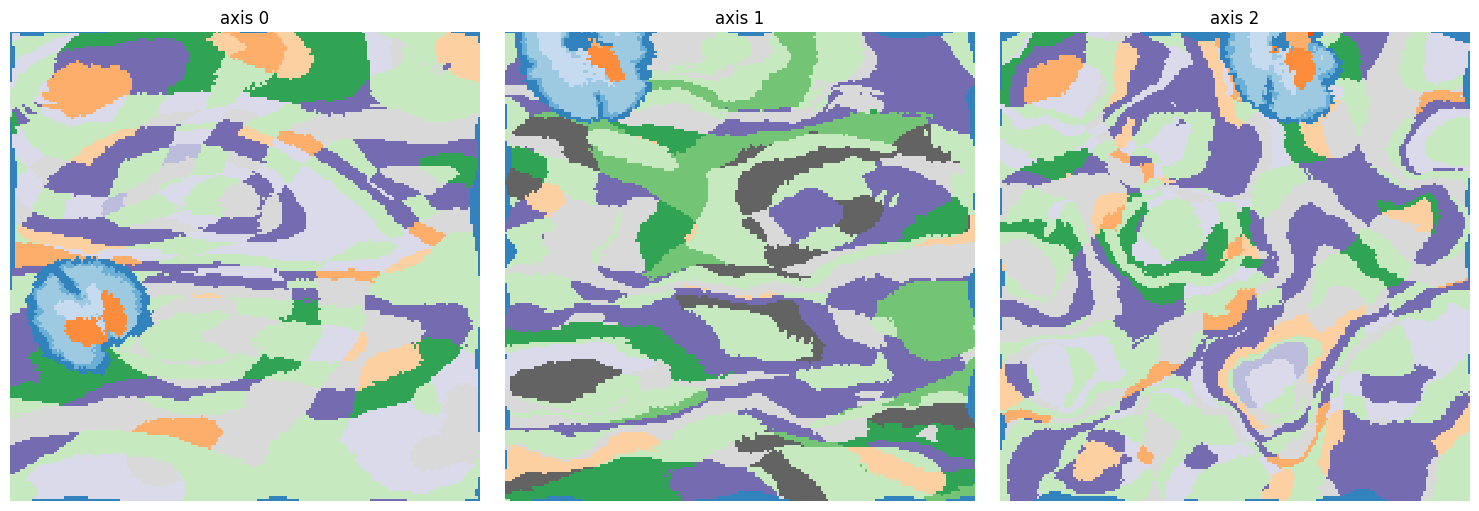

a [ 0  1  2  3  4  5  6  7  9 10 13 17 18 20 22]


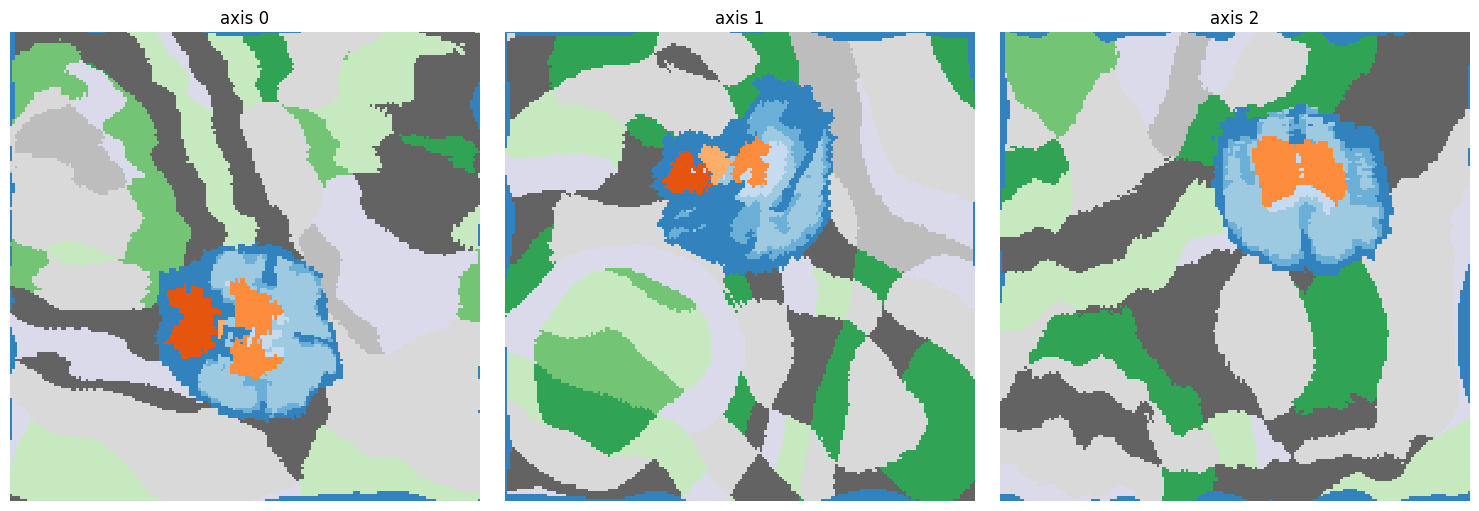

a [ 0  1  2  3  4  5  6  7 10 11 13 16 19 20 21 23]


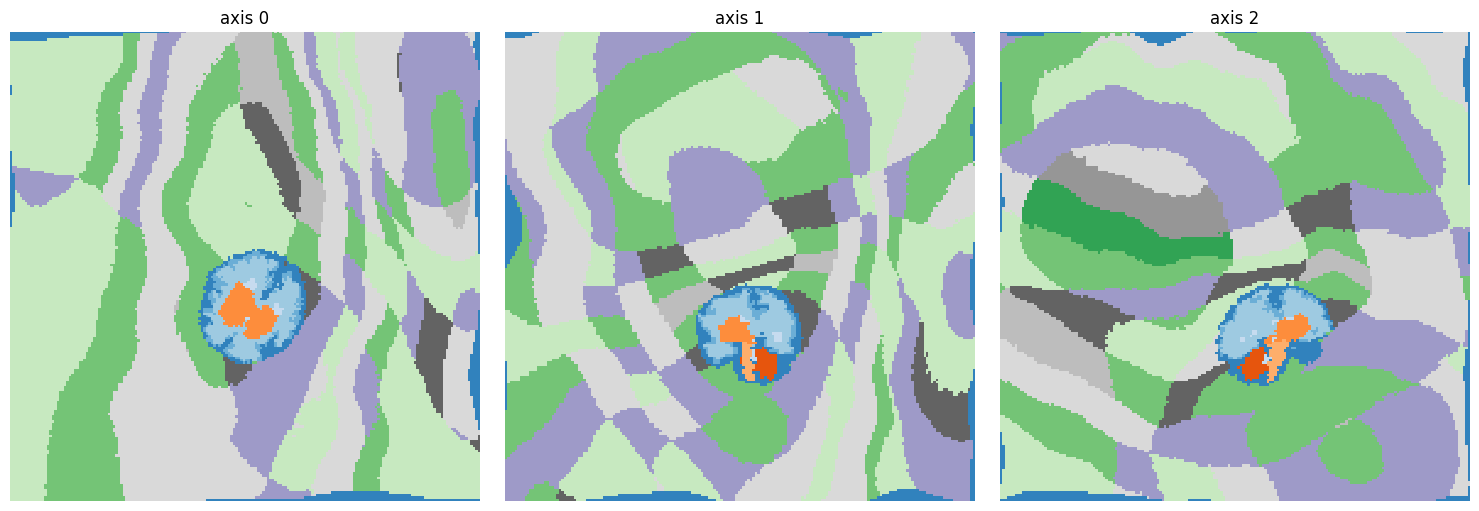

a [ 0  1  2  3  4  5  6  7  9 10 12 13 19]


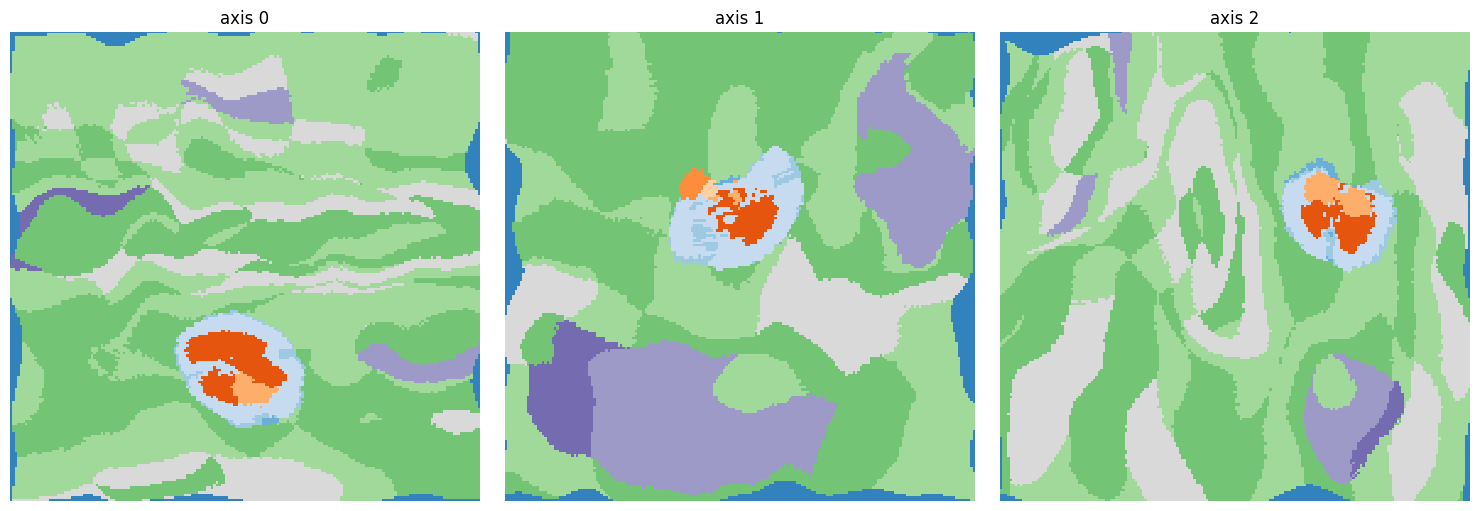

a [ 0  1  2  3  4  5  6  7 10 11 13 16 19 20 21 23]


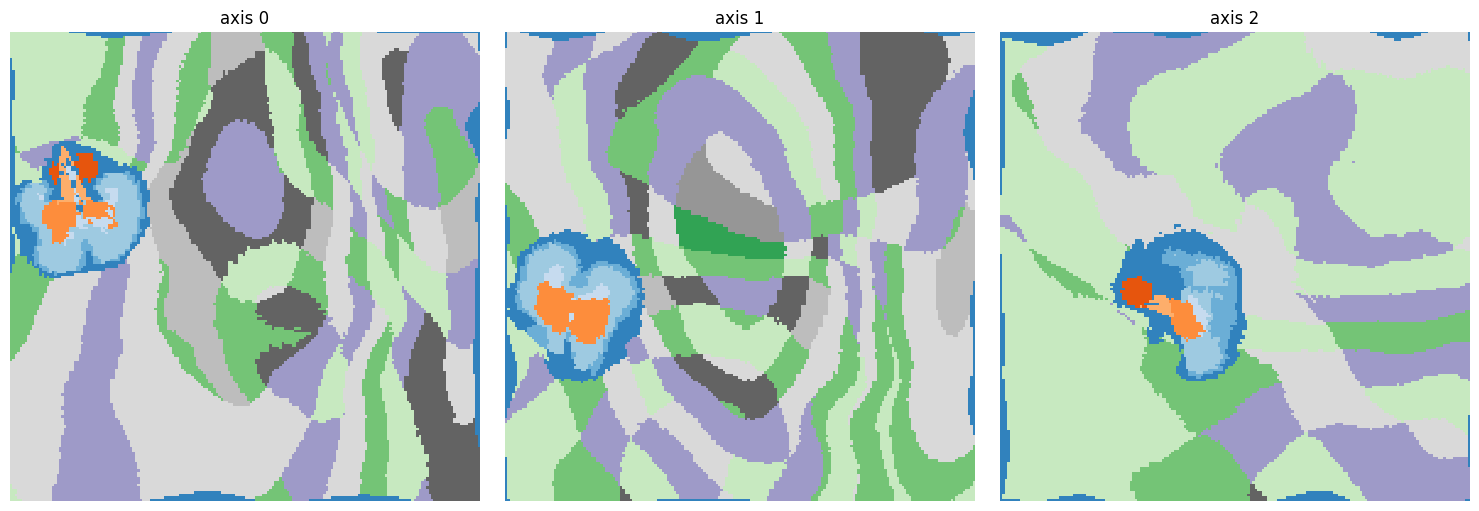

a [ 0  1  2  3  4  5  6  7 12 14 17 19 21 23]


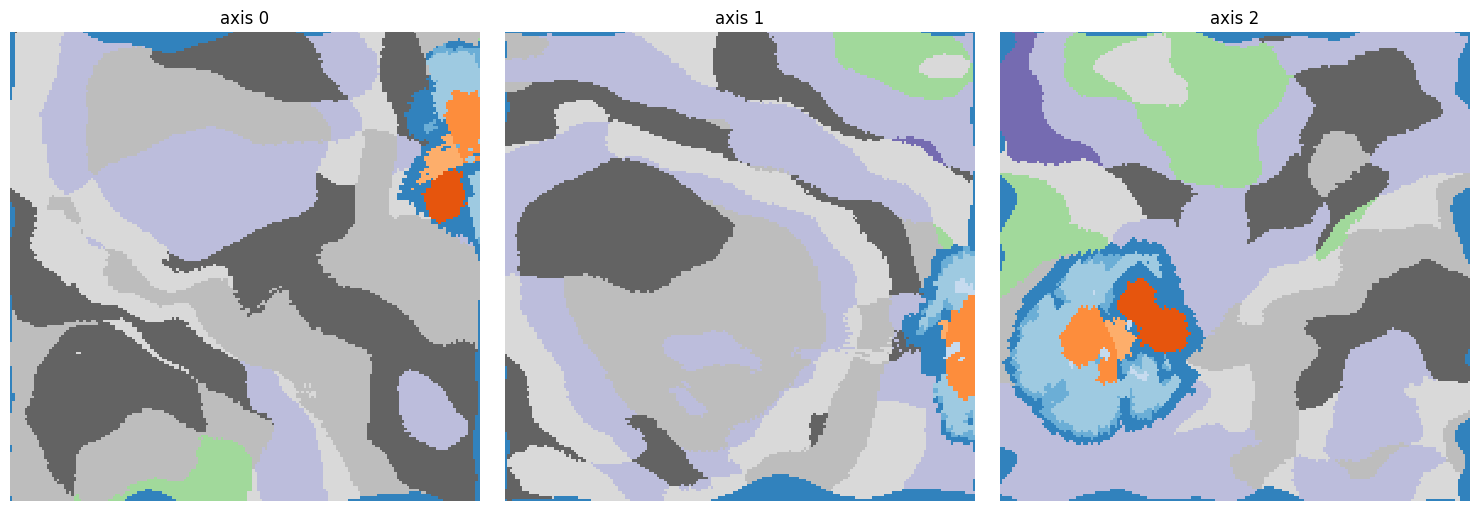

a [ 0  1  2  3  4  5  6  7  8  9 10 13 14 17 18 22 23]


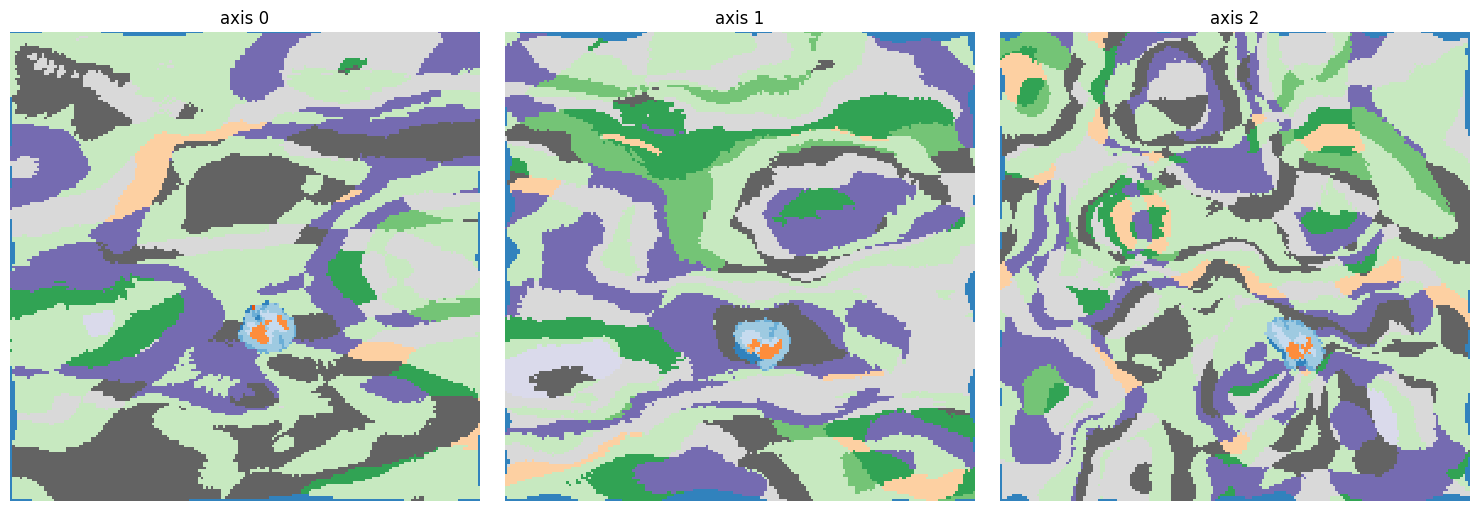

a [ 0  1  2  3  4  5  6  7  9 10 13 17 18 20 22]


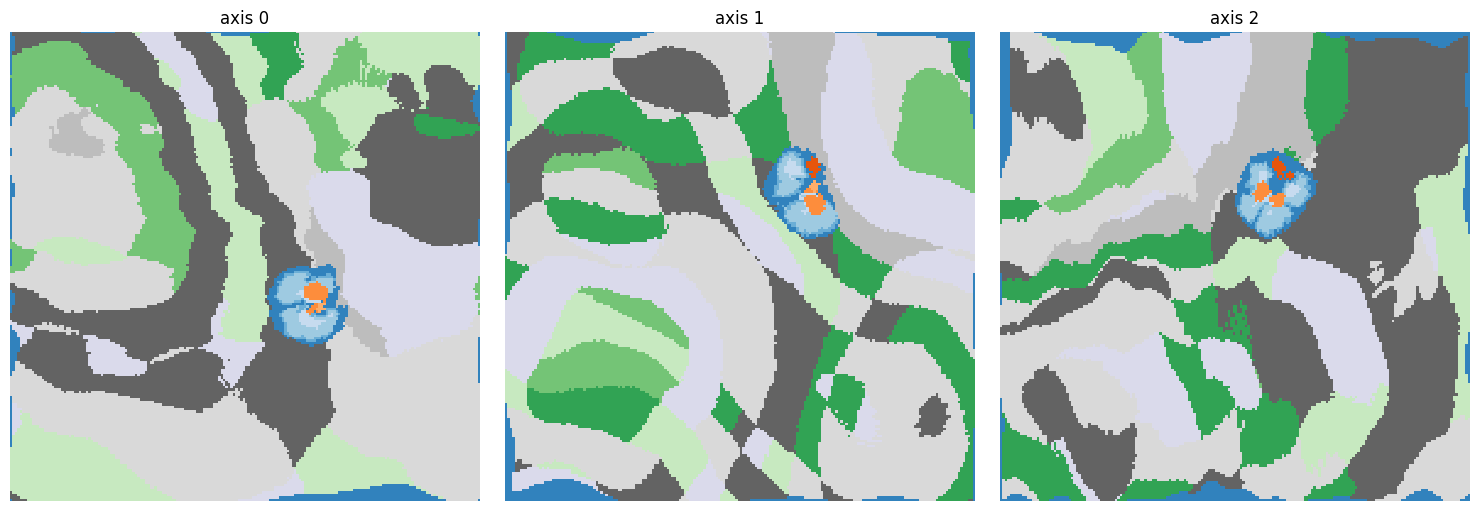

a [ 0  1  2  3  4  5  6  7  9 10 12 13 19]


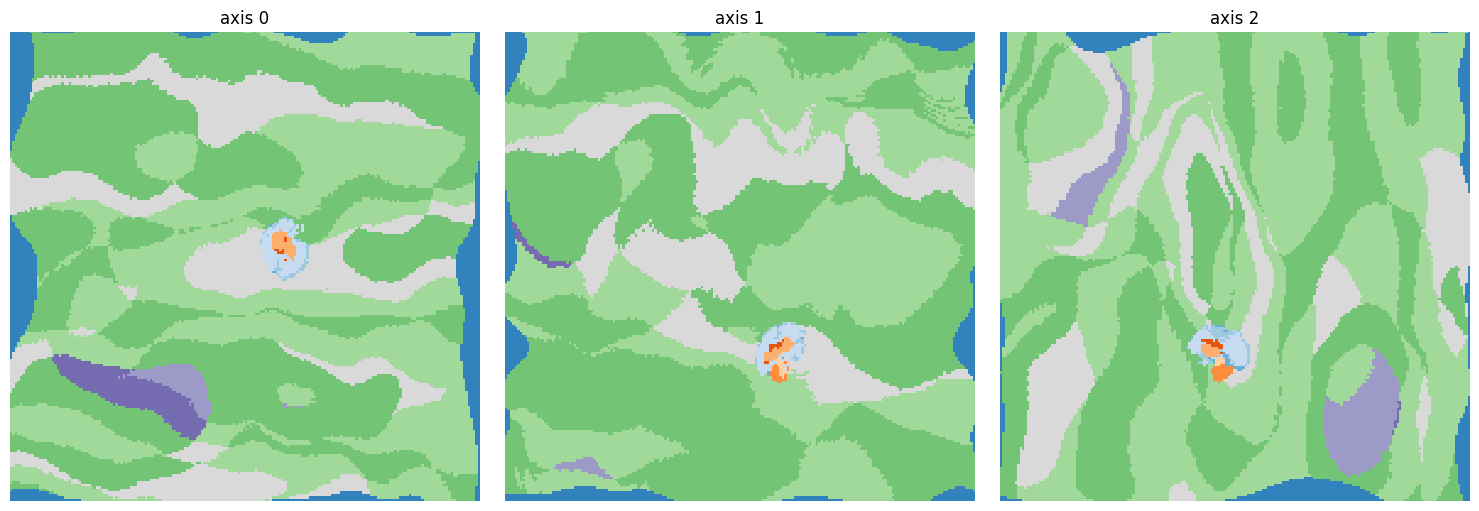

a [ 0  1  2  3  4  6  7  9 10 13 17 18 20 22]


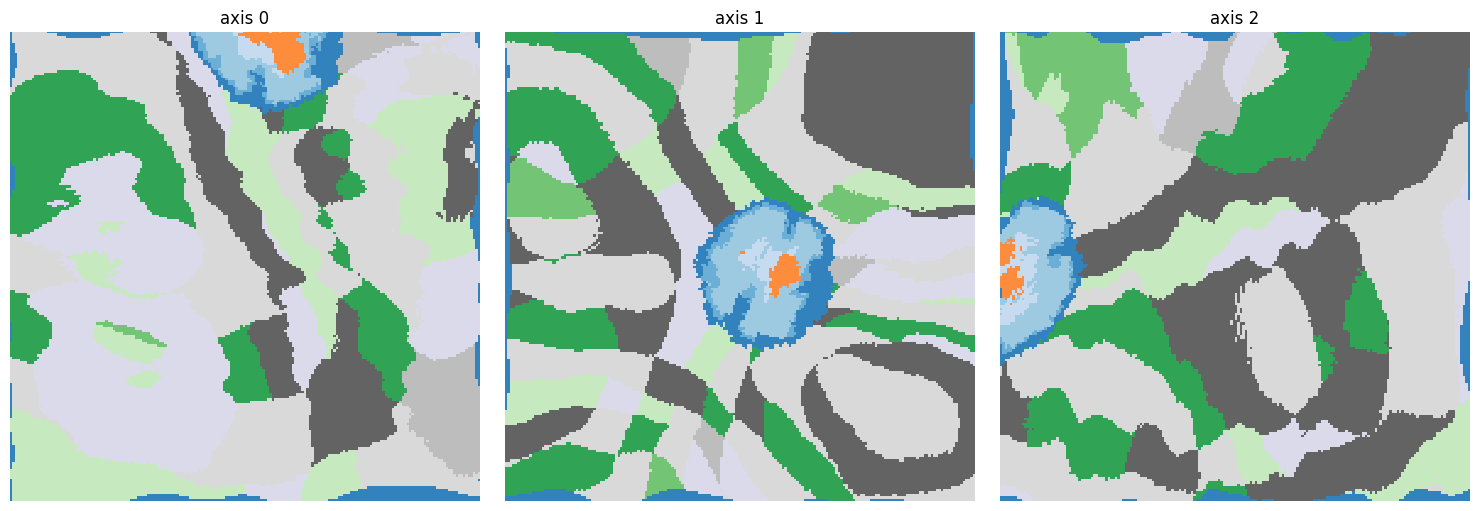

a [ 0  1  2  3  4  5  6  7 10 11 13 16 19 20 21 23]


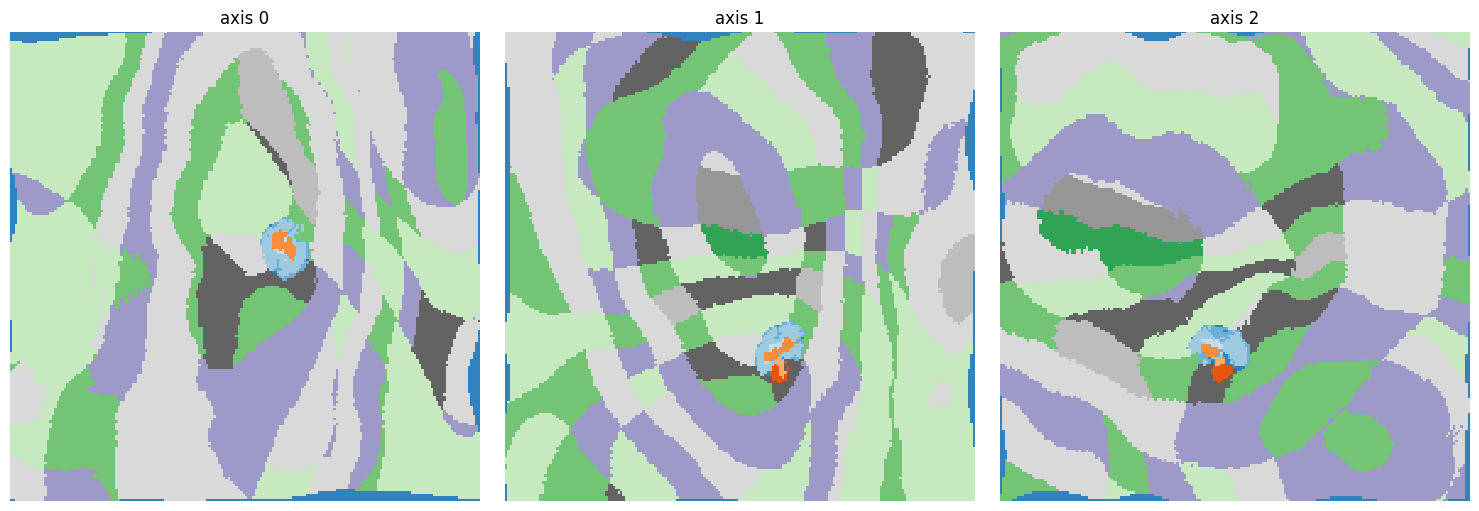

a [ 0  1  2  3  4  5  6  7  9 10 13 17 18 20 22]


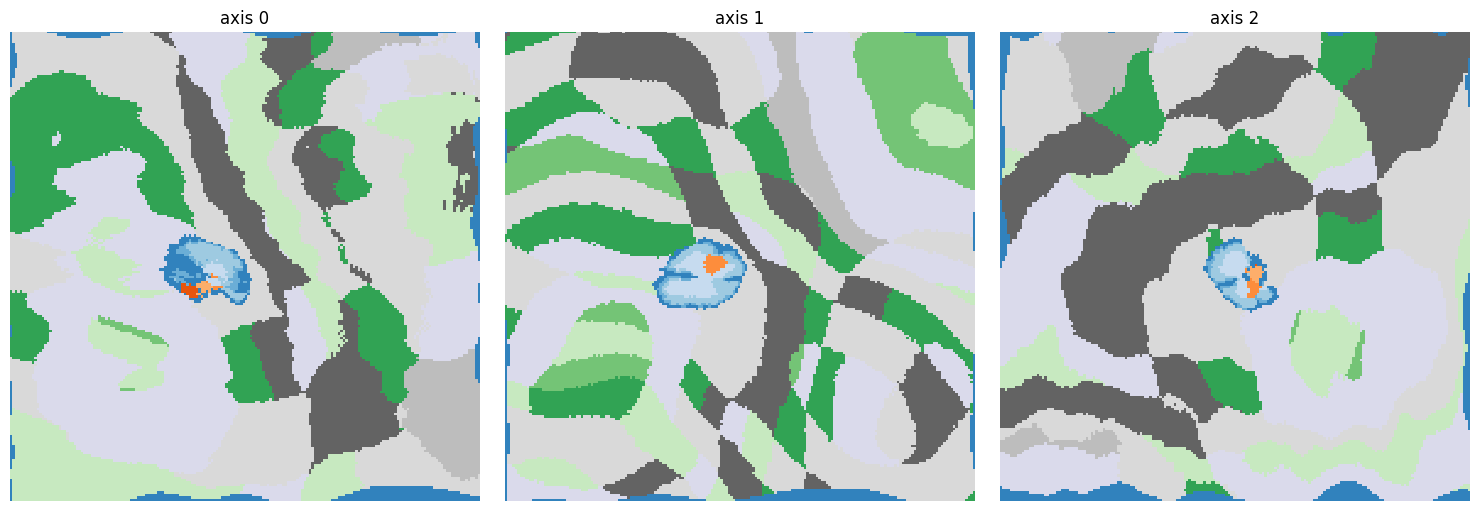

a [ 0  1  2  3  4  5  6  7 12 14 17 19 21 23]


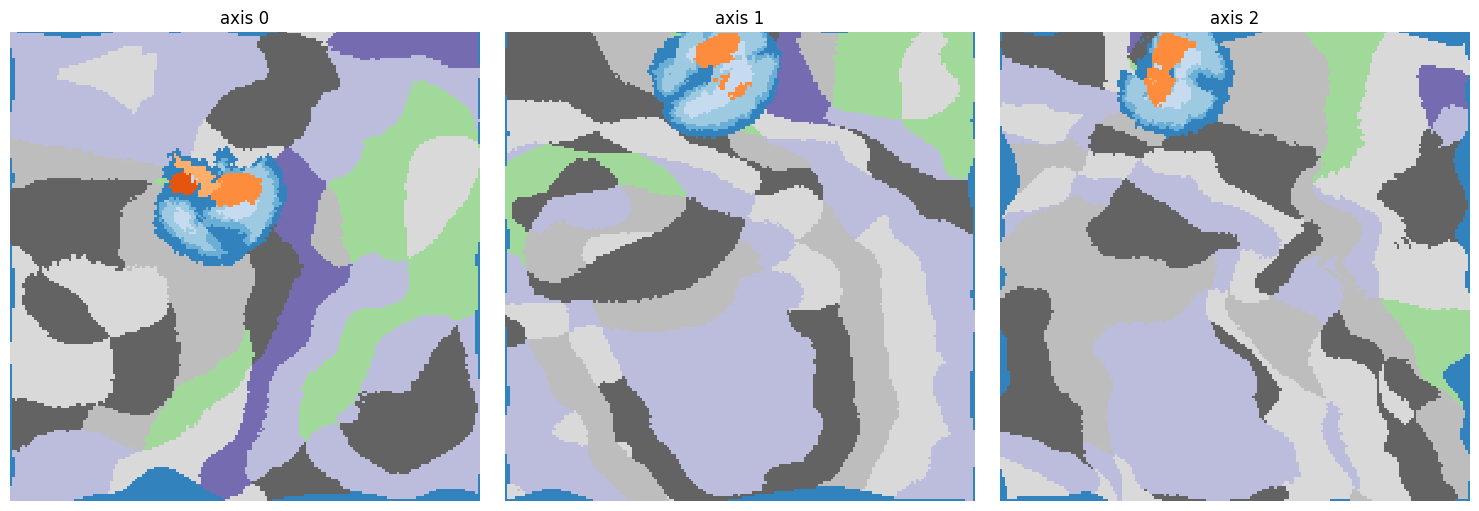

a [ 0  1  2  3  4  5  6  7  9 10 13 17 18 20 22]


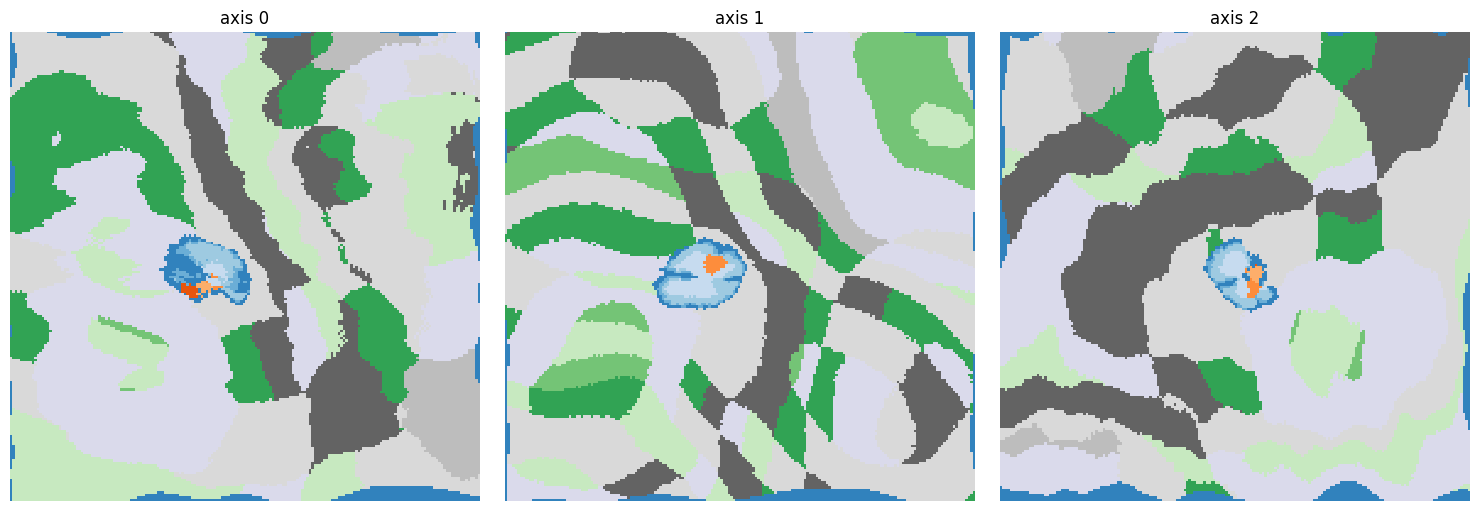

a [ 0  1  2  3  4  5  6  7  8  9 10 13 14 17 18 22 23]


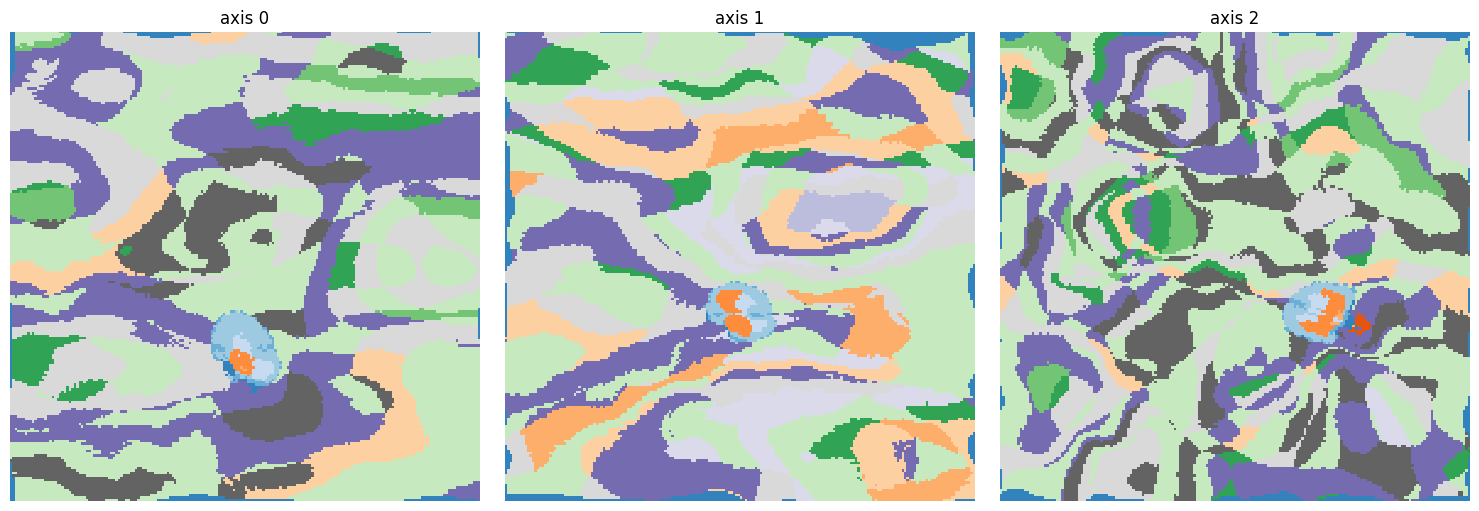

a [ 0  1  2  3  4  5  6  7  8  9 10 13 14 17 18 22 23]


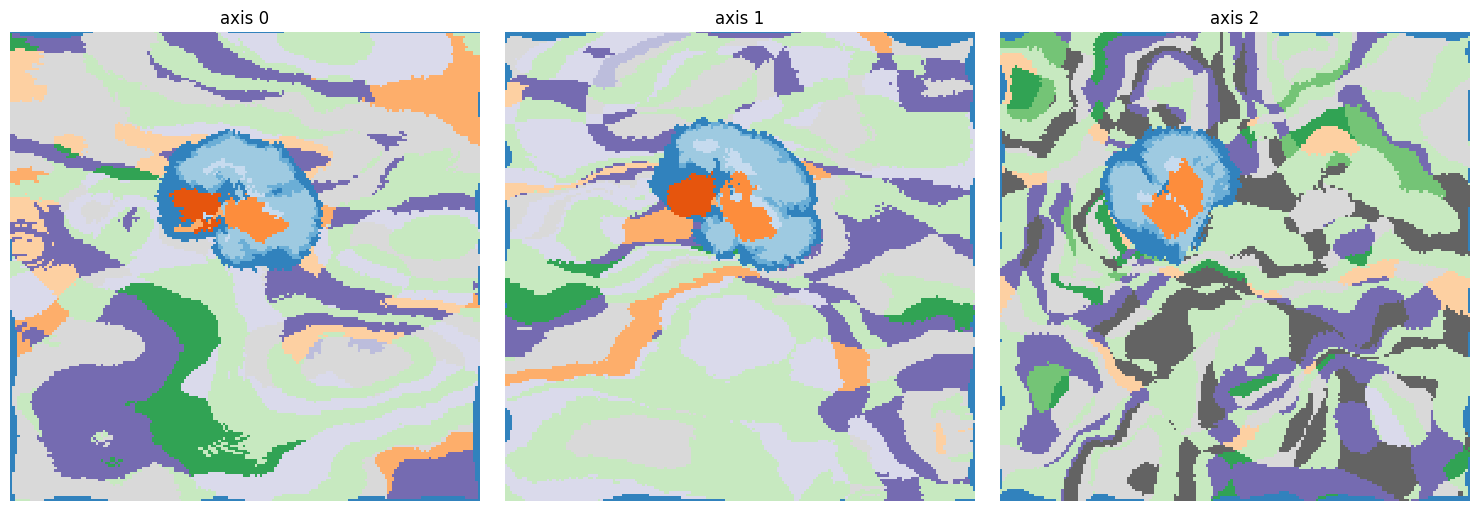

a [ 0  1  2  3  4  5  6  7 10 11 13 16 19 20 21 23]


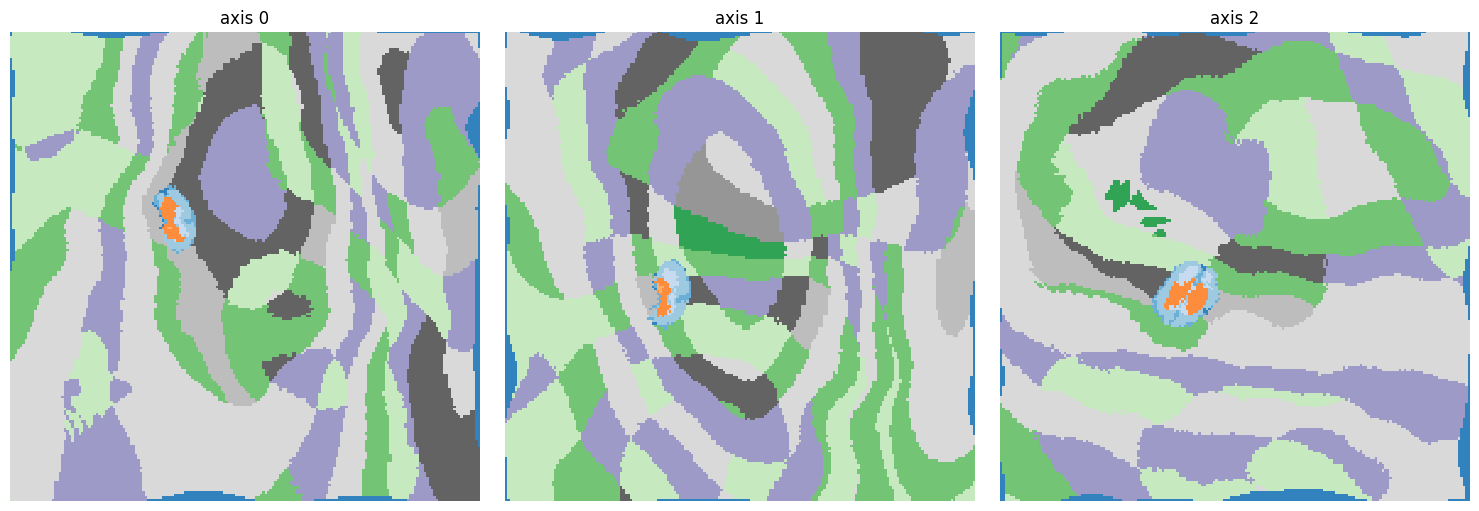

a [ 0  1  2  3  4  5  6  7  9 10 12 13 19]


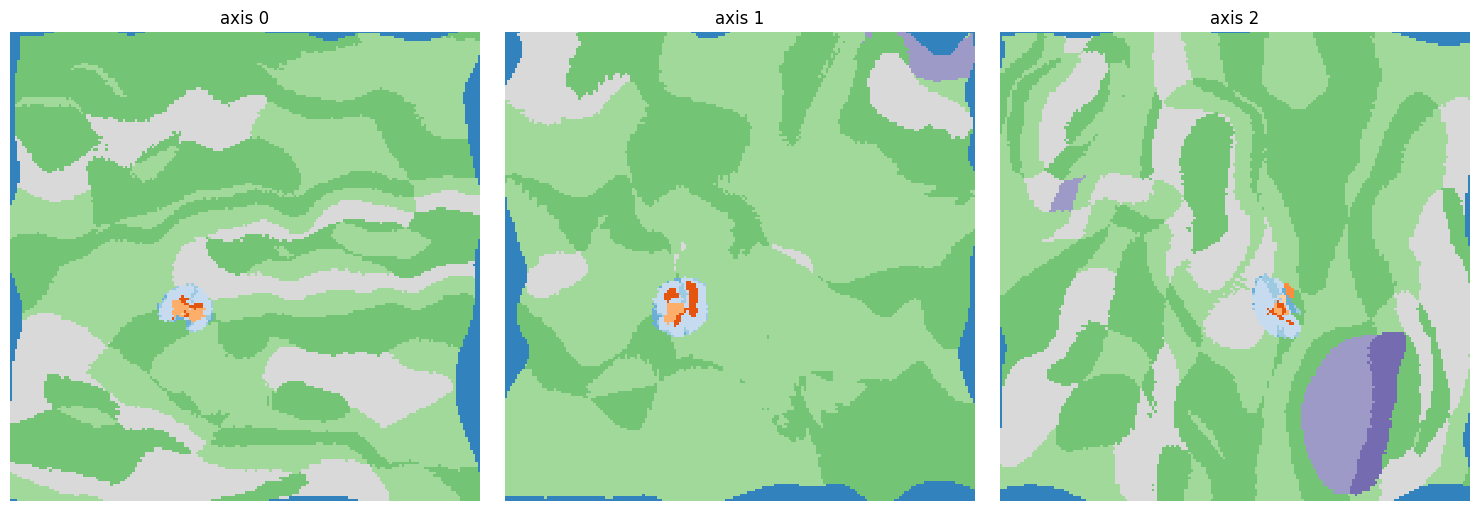

a [ 0  1  2  3  4  6  7  9 10 12 13 19]


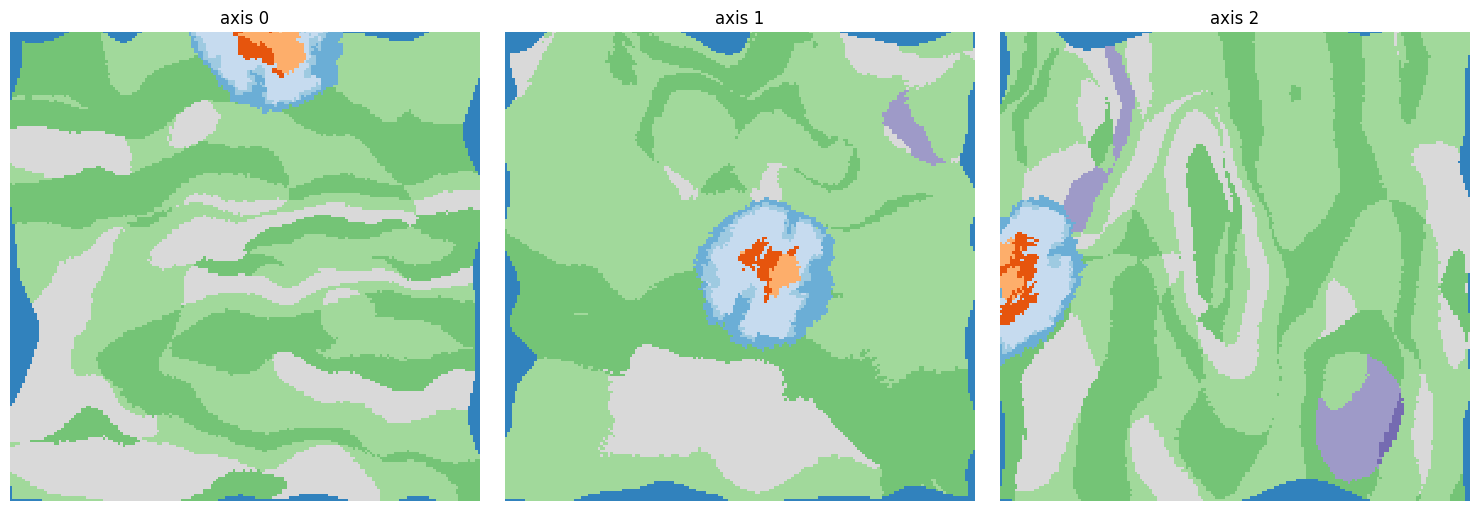

a [ 0  1  2  3  4  5  6  7 10 11 13 16 19 20 21 23]


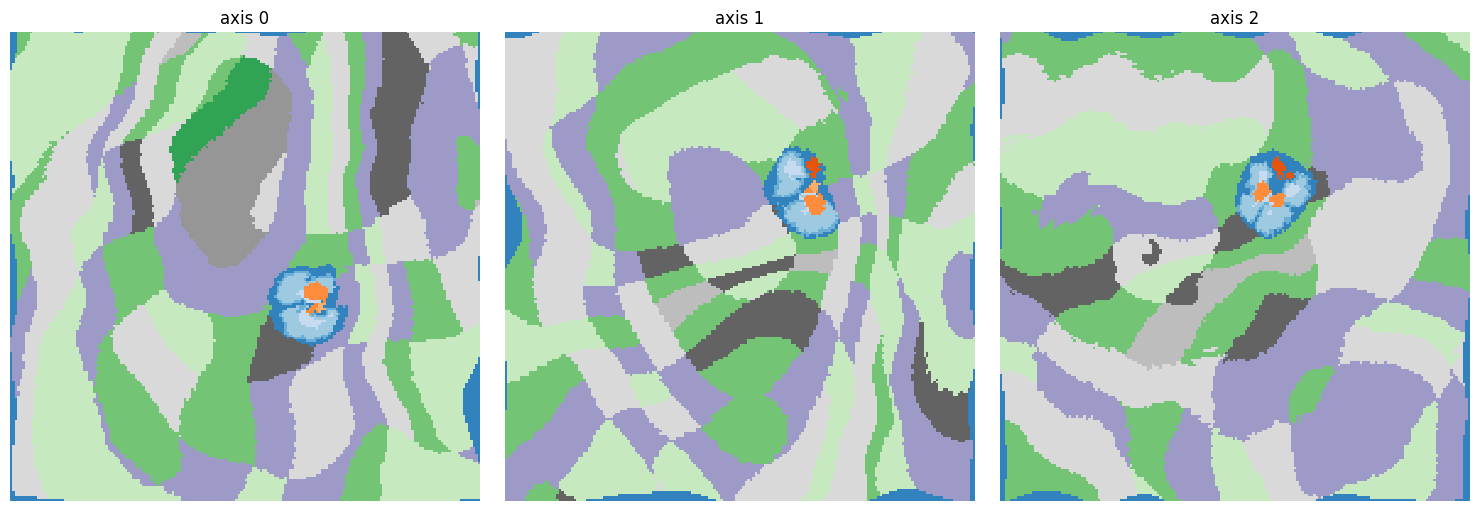

In [14]:
# from scipy.ndimage import binary_erosion
# from scipy.ndimage import binary_dilation

# def create_model(model_config):
#     # print(model_config)
#     return ne.models.labels_to_image_new(**model_config)
    
import json
config = None
with open("params_192.json", "r") as json_file:
    config = json.load(json_file)

# Access the configuration

# model3_config = config["labels_to_image_model_with_shapes"]

# # Convert labels_out keys to integers for all models

# model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

# # Now you have the modified configuration

# model3 = create_model(model3_config)


# Access the configuration
# model1_config = config["brain"]
# model2_config = config["body"]
model_shapes_config = config["shapes"]
model_feta_config = config["feta"]

model3_config = config["labels_to_image_model"]
# model4_config = config["labels_to_image_model_with_shapes_24"]

# Convert labels_out keys to integers for all models
# model1_config["labels_out"] = {int(key): value for key, value in model1_config["labels_out"].items()}
# model2_config["labels_out"] = {int(key): value for key, value in model2_config["labels_out"].items()}

model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

# model4_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
# Now you have the modified configuration
# Brain
# model1 = create_model(model1_config)
# Body
# model2 = create_model(model2_config)

#shapes
# print(model_shapes_config)
# model_shapes = create_model(model_shapes_config)

model_shapes = ne.models.labels_to_image_new(**model_shapes_config)
# Model
labels_to_image_model = create_model(model3_config)



model_feta = create_model(model_feta_config)


in_shape = model_shapes_config["in_shape"]
num_gen = 20
output_labels = []
num_shapes=5
brain_maps = feta_label_maps#get_brain(label_maps)
shapes=[]
def deform(s):
    num_sets = 16
    ind = tf.random.uniform(shape=(num_sets,), maxval=num_sets, dtype=tf.int32)
    ind = tf.cast(ind, dtype=tf.uint8)
    s = tf.cast(s, dtype=tf.int32)  # Convert s to int32
    return tf.gather(ind, indices=s)
shapes = [ draw_shapes_easy(shape = (192,)*3)  for i in range(num_shapes)]   
# shapes = [draw_shapes(in_shape, 8) for _ in range(num_shapes)]

# shapes = map(np.squeeze, shapes)
shapes = [tf.squeeze(shape) for shape in shapes]

# shapes = map(np.uint8, shapes)
shapes = [tf.cast(shape, tf.uint8) for shape in shapes]

shapes = [deform(s) for s in shapes]
shapes = [f + 7 + 1 for f in shapes]
y_shape_list = [y_shape for _, y_shape in [model_shapes(s[None,...,None]) for s in shapes]]
# print(len(shapes),shapes[0].shape)
# s = shapes[0]
# _, y_shape = model_shapes(s[None,...,None])

brain_maps = map(np.uint8, brain_maps)
y_brain_list = [y_brain for _, y_brain in [model_feta(s[None,...,None]) for s in brain_maps]]
# shapes = map(np.squeeze, y_brain_list)
# y_shape_list = map(np.uint8, y_shape_list)
# y_brain_list = map(np.uint8, y_brain_list)

gen = generator_feta_shapes(y_brain_list, y_shape_list)

for i in range(num_gen):

    

    output_label = next(gen)
    print("a",np.unique(output_label))
    output_labels.append(output_label)
    nib.save(nib.Nifti1Image(np.squeeze(output_label, axis=(0, -1)).astype(np.int32), np.eye(4), header=None), f"samples/feta_shapes_label_map_{i}.nii.gz")
    
    label_map = np.squeeze(output_label, axis=(0, -1))
    
    mean_slice_numbers = tuple(np.median(np.where(np.isin(label_map, [1, 2, 3, 4, 5, 6, 7])), axis=1))
    if np.isnan(mean_slice_numbers).any():
        print("mean_slice_numbers:",mean_slice_numbers)
        continue
        
    ne.plot.volume3D(label_map, cmaps=['tab20c'],slice_nos=mean_slice_numbers);
    

# ne.plot.volume3D(s, cmaps=['tab20c'])
# ne.plot.volume3D(np.squeeze(y_shape,axis=(0,-1)), cmaps=['tab20c'])


In [4]:
mean_slice_numbers

(nan, nan, nan)

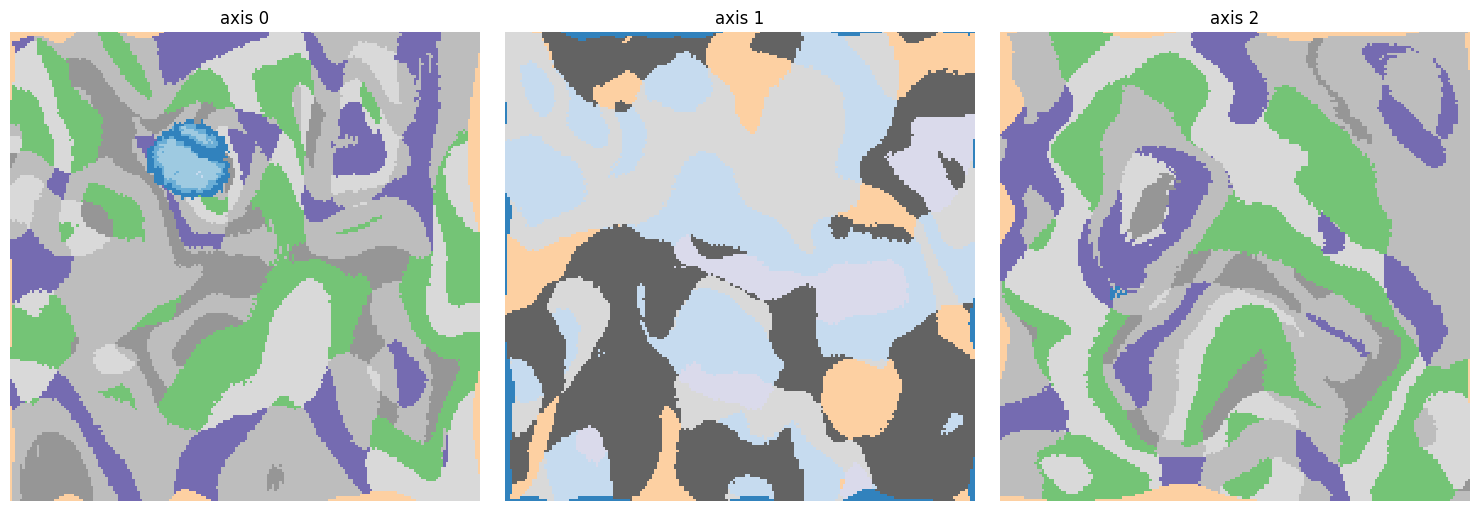

In [12]:
# print(np.unique(y_shape_list),np.unique(y_brain_list),[np.unique(output_labels[i]) for i in range(num_gen)])
input_img = feta_label_maps[0]
_, fg = model_feta(input_img[None,...,None])
shapes = draw_shapes_easy(shape = (192,)*3)

shapes = tf.squeeze(shapes)
shapes = tf.cast(shapes, tf.uint8)

shapes = deform(shapes)
_, bg = model_shapes(shapes[None,...,None])
bg = bg + 8
fg_inner = fg[0, ..., 0]
bg_inner = tf.reshape(bg[0, ..., 0], fg_inner.shape)
mask = tf.cast(tf.equal(fg_inner, 0), fg_inner.dtype)
result = fg_inner + bg_inner * mask

ne.plot.volume3D(result, cmaps=['tab20c'])

# label_map = fg + bg * (fg == 0)
# generated_img , y = labels_to_image_model(label_map)


In [86]:
# np.unique(result)
# fg.shape
# input_img.shape
# a = draw_shapes_easy(shape = (192,)*3)
# a = tf.squeeze(a)
# a = tf.cast(a, tf.uint8)
# a = deform(a)
# _,a = model_shapes(a[None,...,None])
# bg = a + 8
# fg_inner = fg[0, ..., 0]
# bg_inner = tf.reshape(bg[0, ..., 0], fg_inner.shape)
# mask = tf.cast(fg_inner == 0, tf.int32)
# result = fg_inner + bg_inner * mask

# ne.plot.volume3D(result, cmaps=['tab20c'])
for i in range(len(output_labels)):
    print(np.unique(output_labels[i]))

[ 0  1  2  3  4  5  6  7  8  9 17 18 20 21 22 23]
[ 0  1  2  3  4  5  6  7 15 18 22 23]
[ 0  1  2  3  4  5  6  7  8 12 13 14 20 22 23]
[ 0  1  2  3  4  5  6  7 15 18 22 23]
[ 0 15 18 22 23]
[ 0  1  2  3  4  5  6  7  8  9 17 18 20 21 22 23]
[ 0  1  2  3  4  5  6  7 15 18 22 23]
[ 0  1  2  3  4  5  6  7  8 11 16 17 18 19 22 23]
[ 0  8  9 17 18 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8 11 16 17 18 19 22 23]
[ 0  1  2  3  4  5  6  7 15 18 22 23]
[ 0  1  2  3  4  5  6  7  8 11 16 17 18 19 22 23]
[ 0  1  2  3  4  5  6  7  8 11 16 17 18 19 22 23]
[ 0  1  2  3  4  5  6  7  8 11 16 17 18 19 22 23]
[ 0  1  2  3  4  5  6  7  8  9 17 18 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 17 18 20 21 22 23]
[ 0  1  2  3  4  5  6  7  9 10 11 12 16 18 19 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 17 18 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8 12 13 14 20 22 23]
[ 0  1  2  3  4  5  6  7 15 18 22 23]


In [81]:
# ne.plot.volume3D(y_shape_list[2], cmaps=['tab20c'])f\
# bg
# np.unique(fg)

# Test Sampling Params

In [5]:

# def sample_isomorphic_scale(lim, shape, normal, trunc, seed):
#     #a = sample(lim, (1,), normal, trunc, seed)
#     a = sample(lim, (), normal, trunc, seed)
#     a = tf.reshape(a, shape)
#     print(a)
#     return a
# def sample(lim, shape, normal, trunc, seed):
#     prop = dict(dtype=tf.dtypes.as_dtype(dtype), seed=seed, shape=shape)
#     func = "uniform"
#     prop.update(minval=-lim, maxval=lim)
#     return getattr(tf.random, func)(**prop)
# seed = 1
# ndims =3
# n = 1 if ndims == 2 else 3
# scale=0.2
# shear=0
# batch_shape = None
# splits = dict(shift=ndims, rot=n, scale=ndims, shear=n)
# inputs = dict(shift=0, rot=180, scale=scale, shear=shear)
# trunc = dict(shift=False, rot=False, scale=True, shear=False)
# normal = dict(
#     shift=False, rot=False, scale=False, shear=False
# )


# shapes = {}
# ranges = {}
# dtype=tf.float32
# for k, n in splits.items():
#     x = np.ravel(0 if inputs[k] is None else inputs[k])
#     if len(x) == 1:
#         x = np.repeat(x, repeats=n)
#     assert len(x) == n, f"unexpected number of parameters {len(x)} ({k})"
#     ranges[k] = x
#     shapes[k] = (
#         (n,) if batch_shape is None else tf.concat((batch_shape, [n]), axis=0)
#     )

# par = {}
# seeds={}
# for k, lim in ranges.items():
#     #if k == 'scale' and not up_scale:
#     #    lim = tf.cast(lim, dtype=tf.float32)
#     #    lim = tf.clip_by_value(lim, 0, 1)  # Consider only scaling factors less than 1 (downscaling)
#     if k == 'scale':
#         par[k] = sample_isomorphic_scale(lim, shapes[k], normal[k], trunc[k], seed=seeds.pop(k, None))
#     else:
#         par[k] = sample(lim, shapes[k], normal[k], trunc[k], seed=seeds.pop(k, None))



In [6]:
np.unique(shapes)

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23],
      dtype=uint8)

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 56191


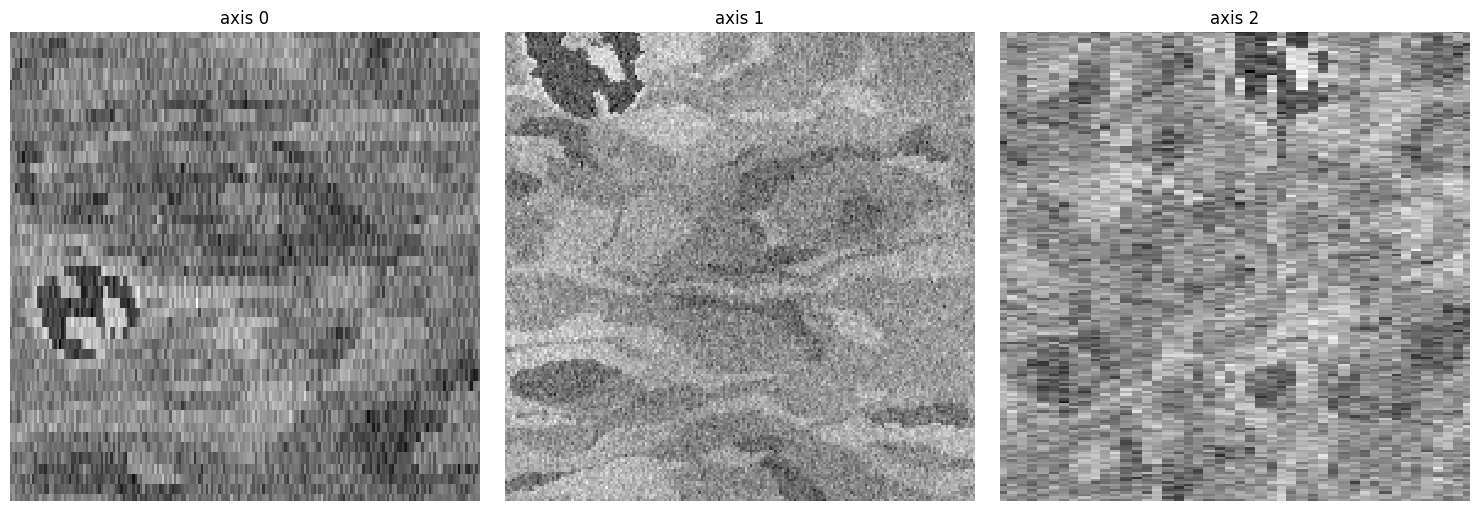

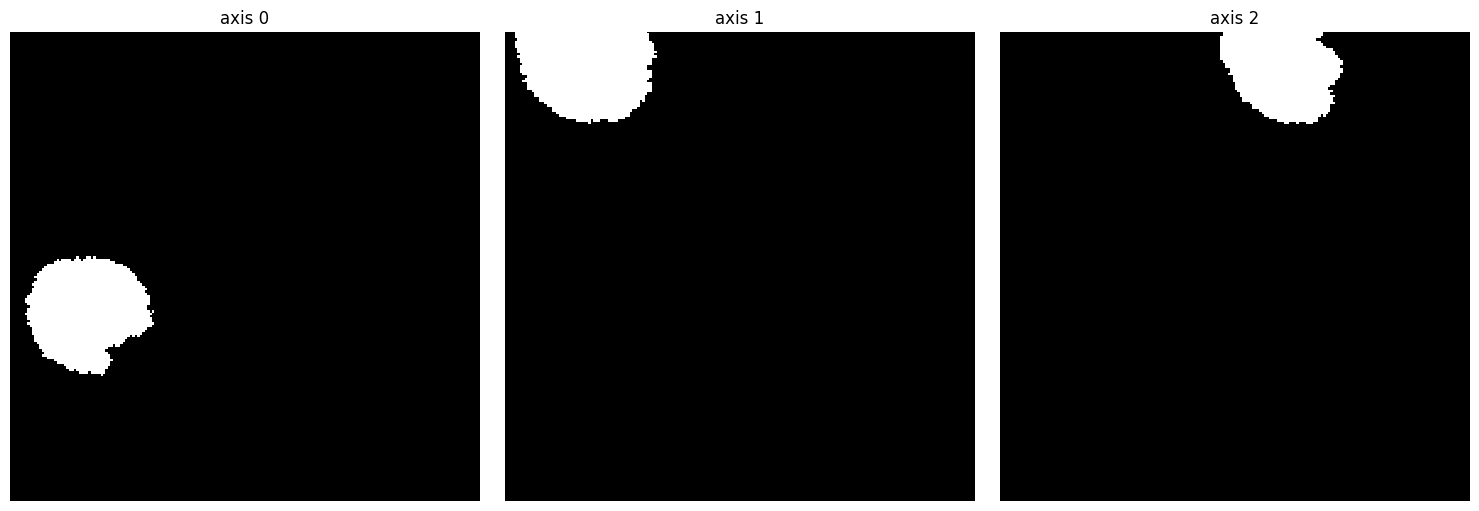

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 225057


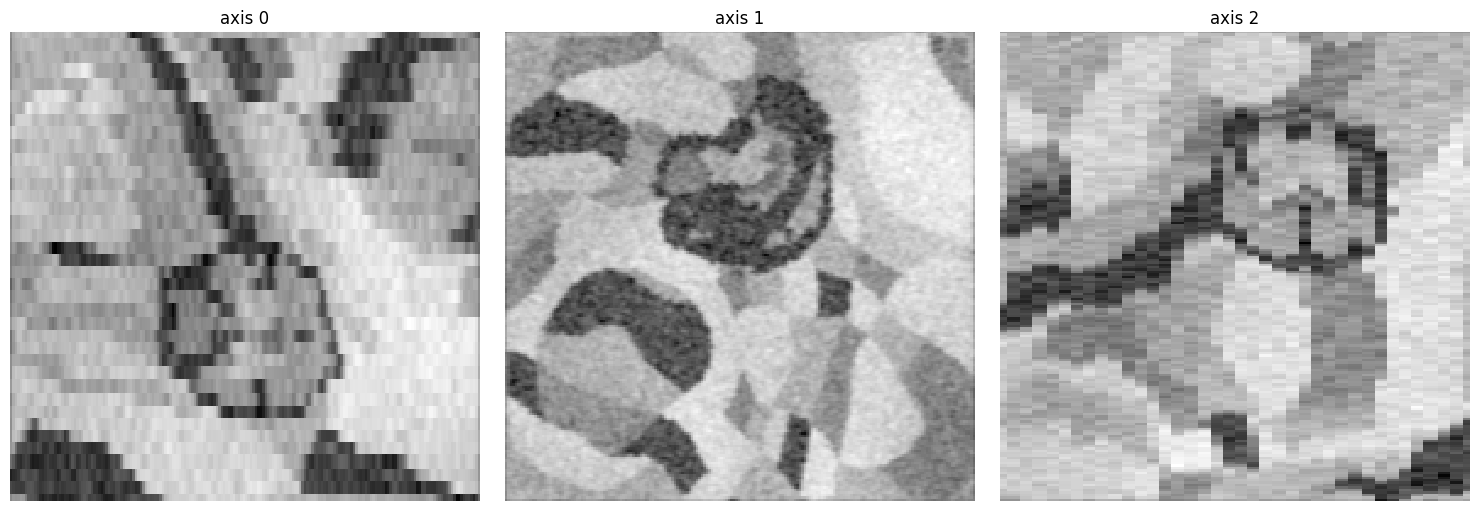

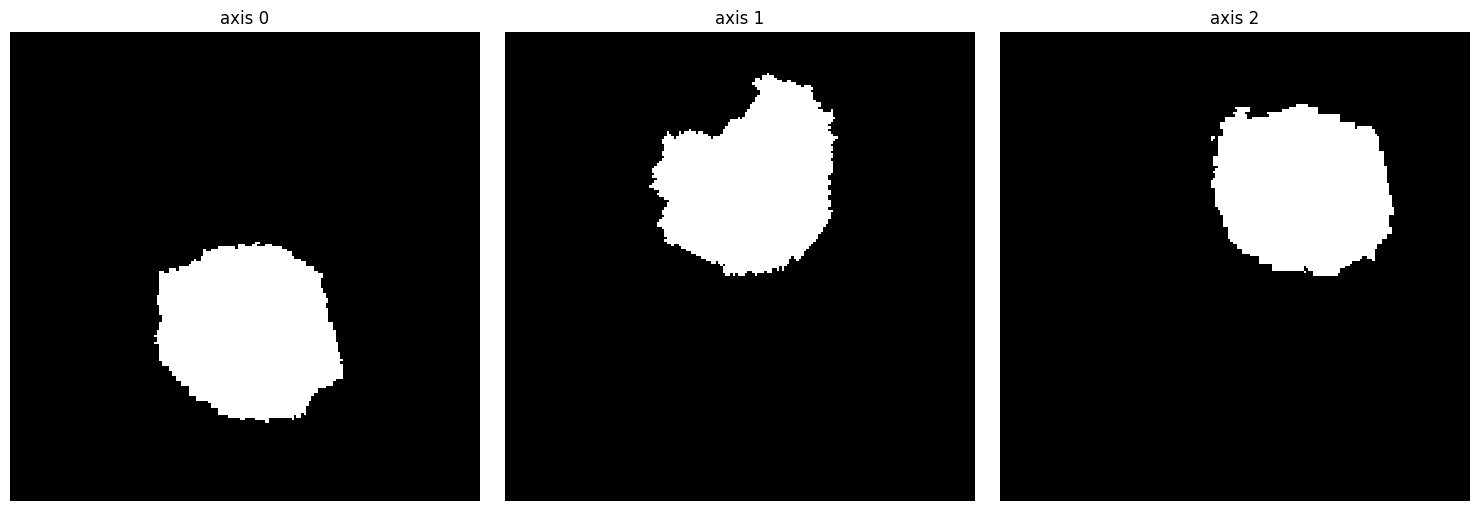

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 41015


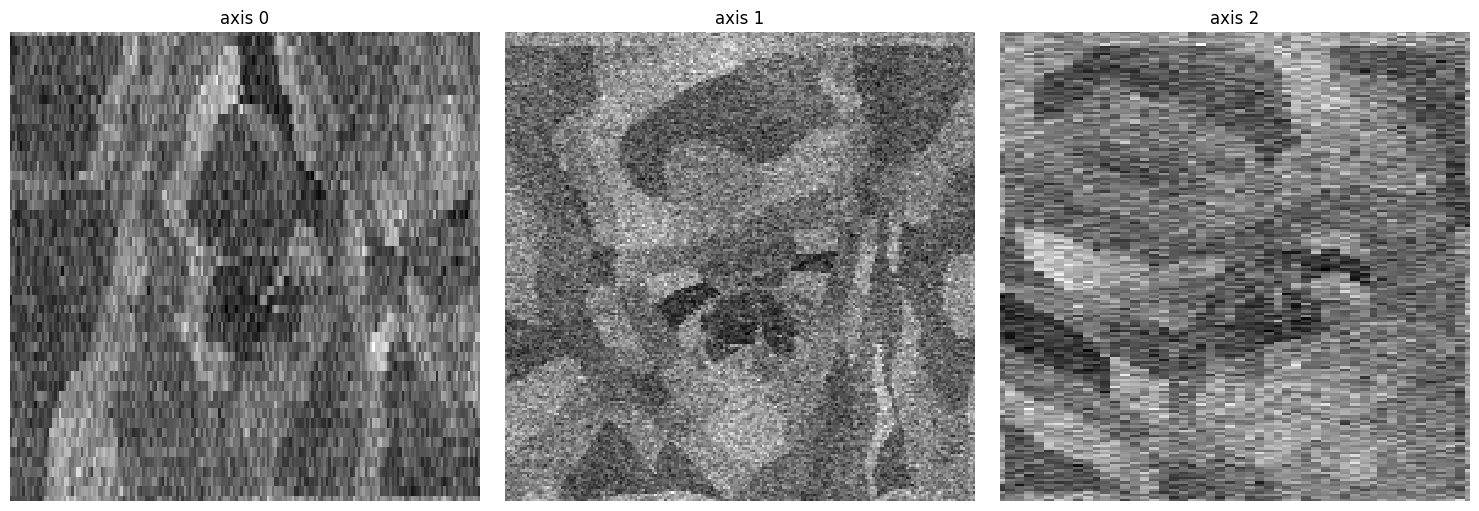

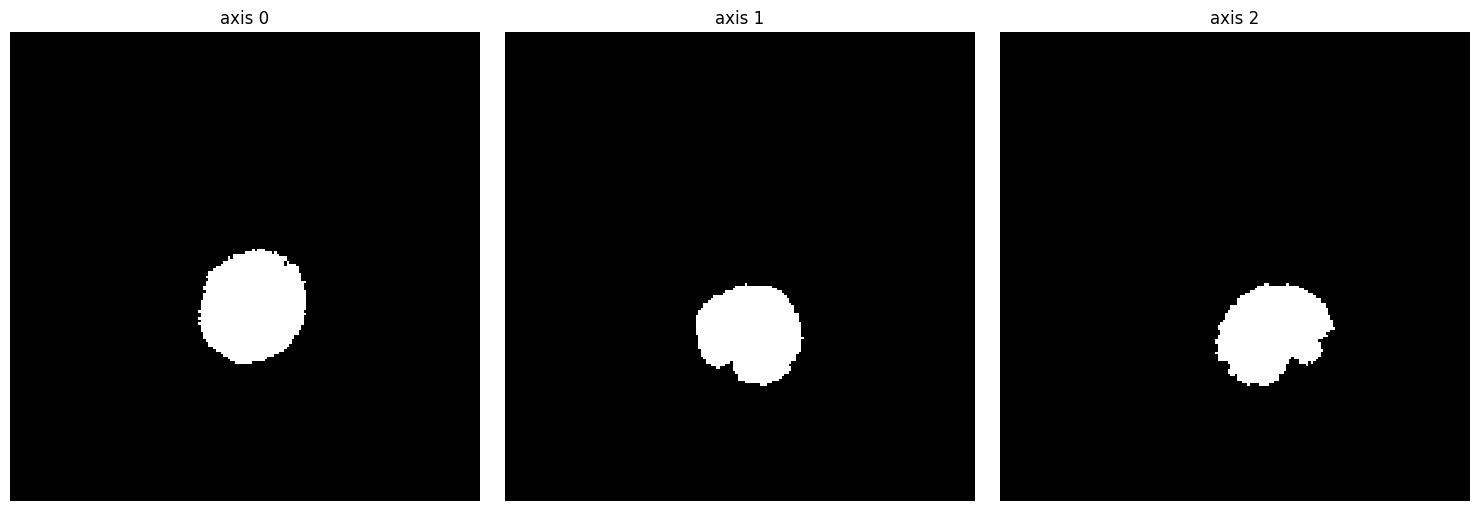

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 61600


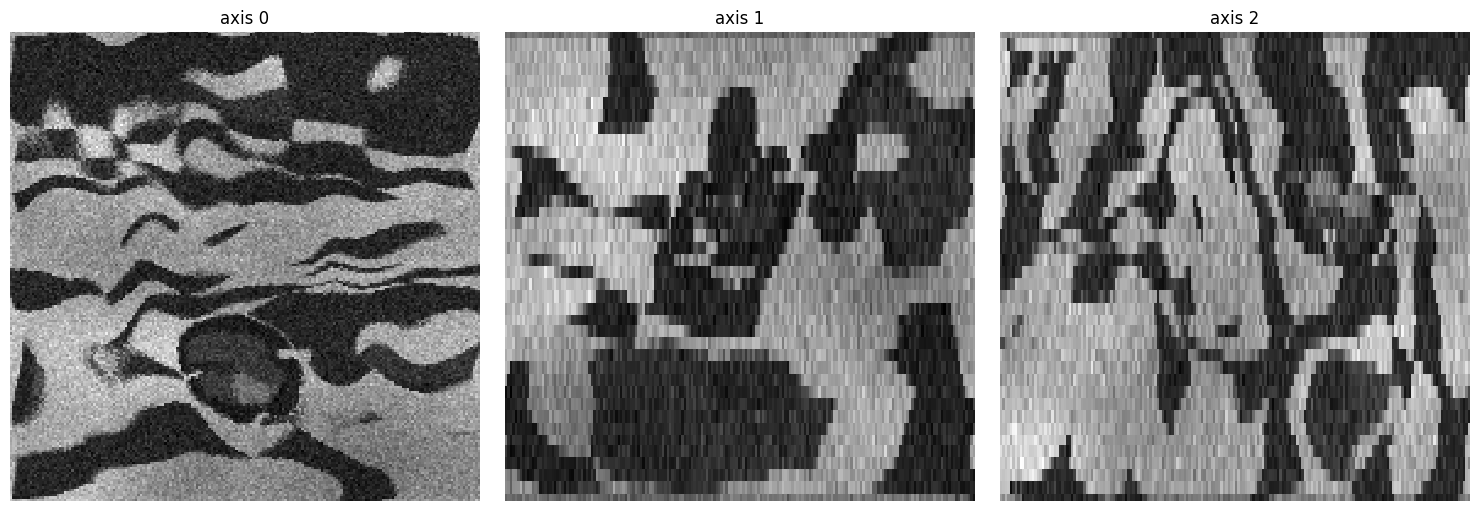

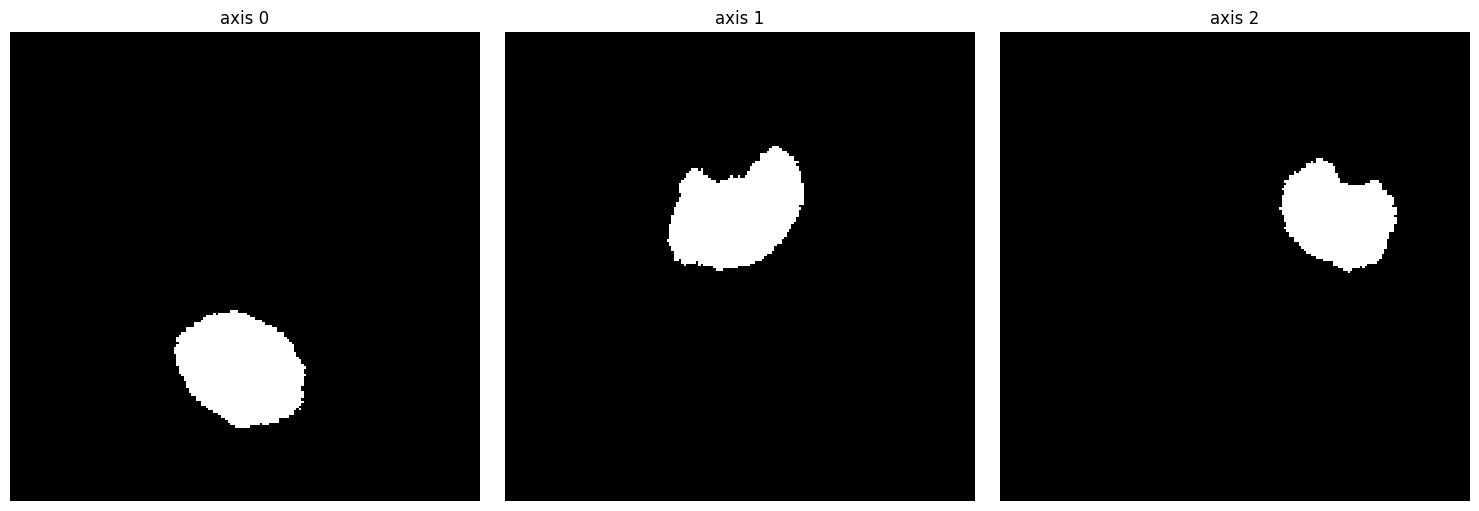

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 90113


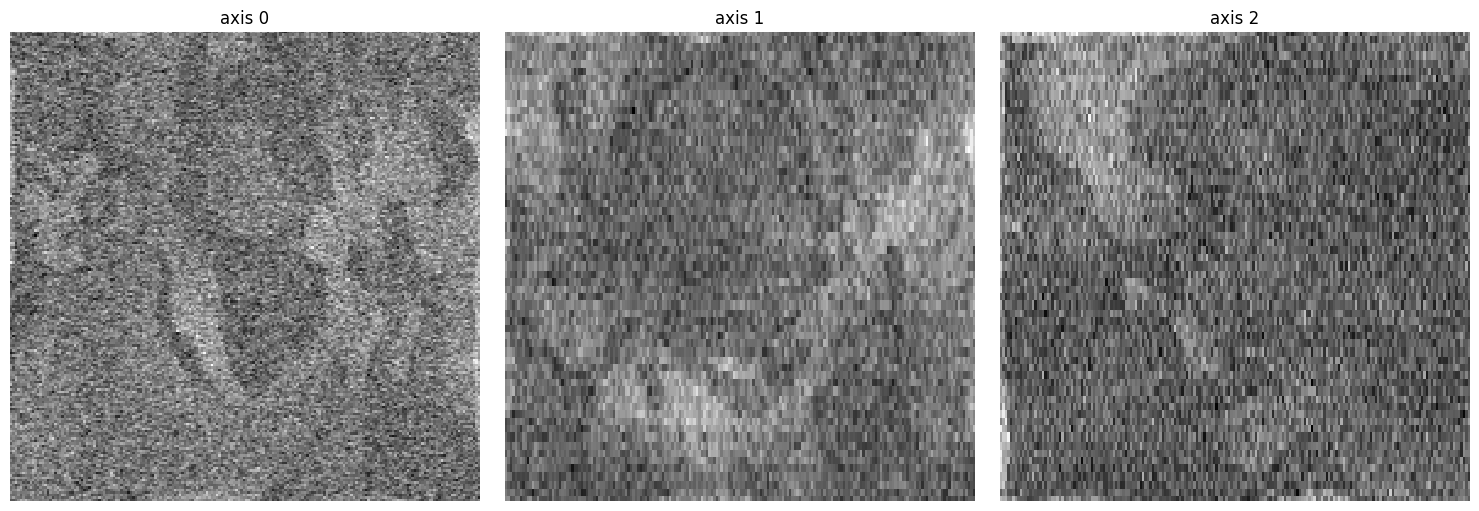

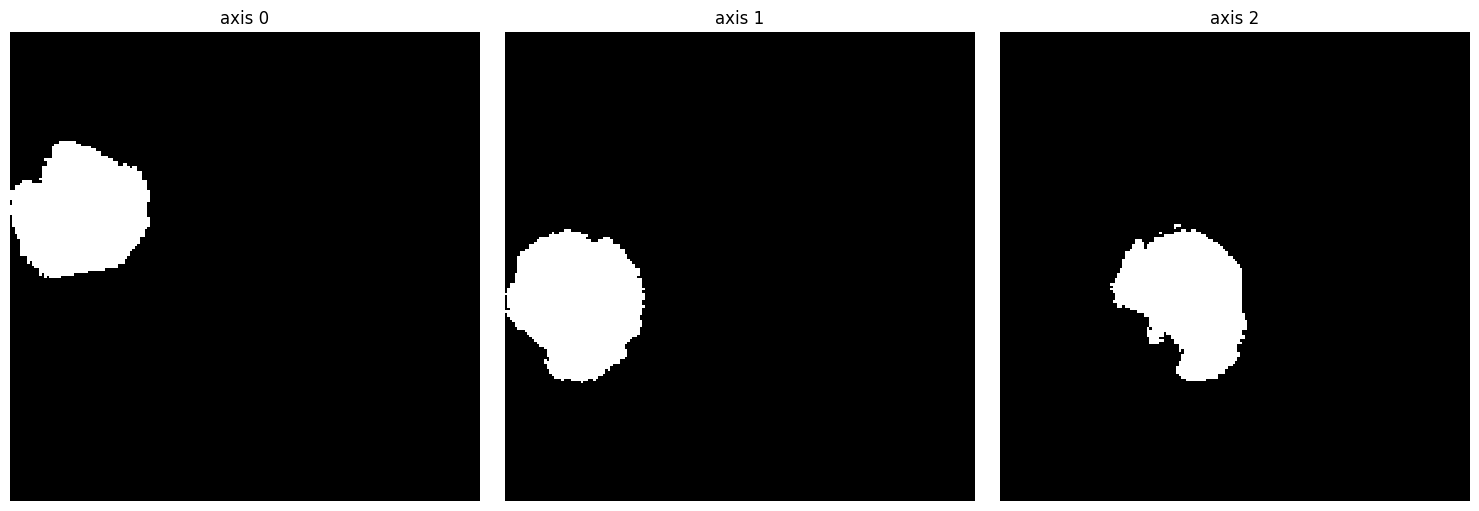

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 109302


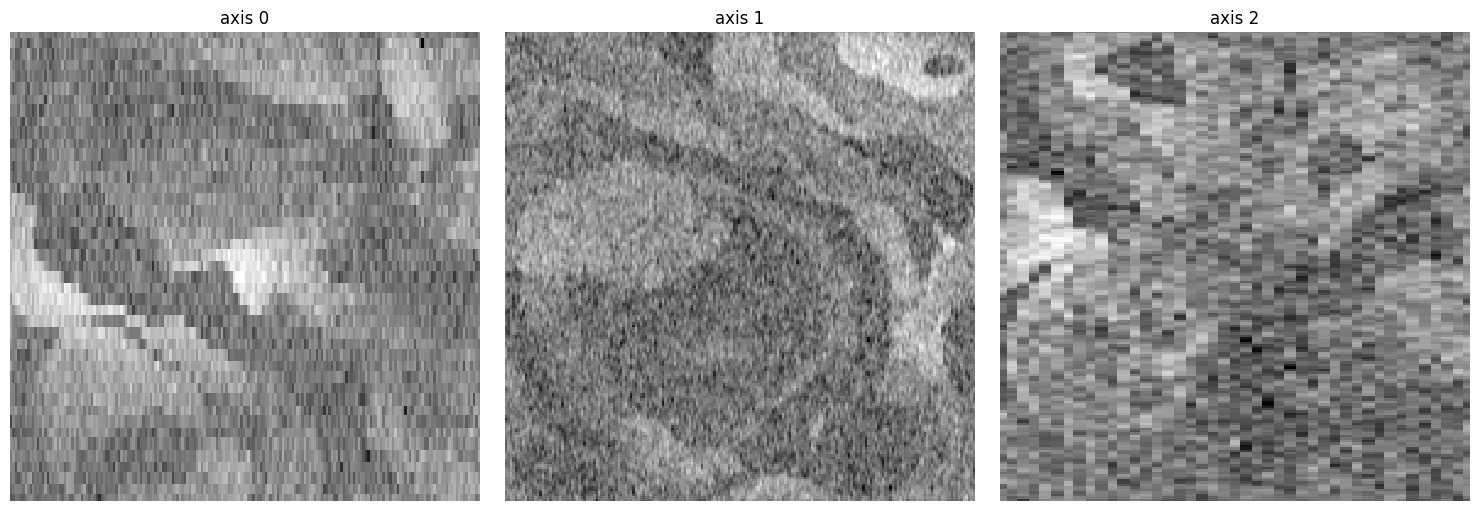

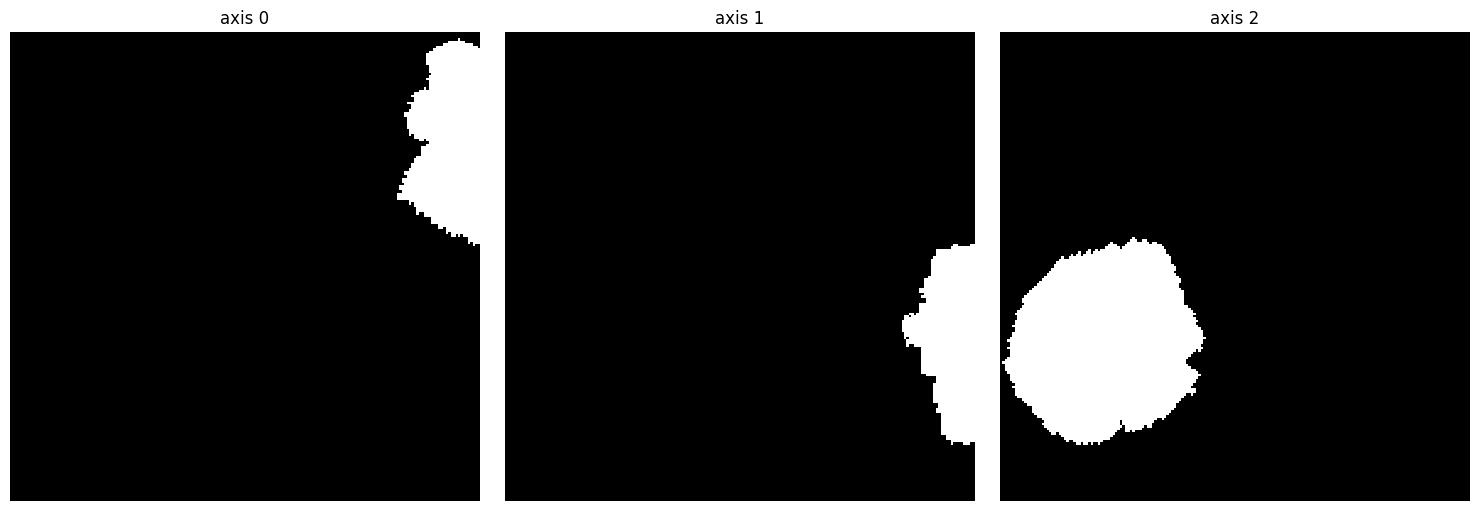

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 5746


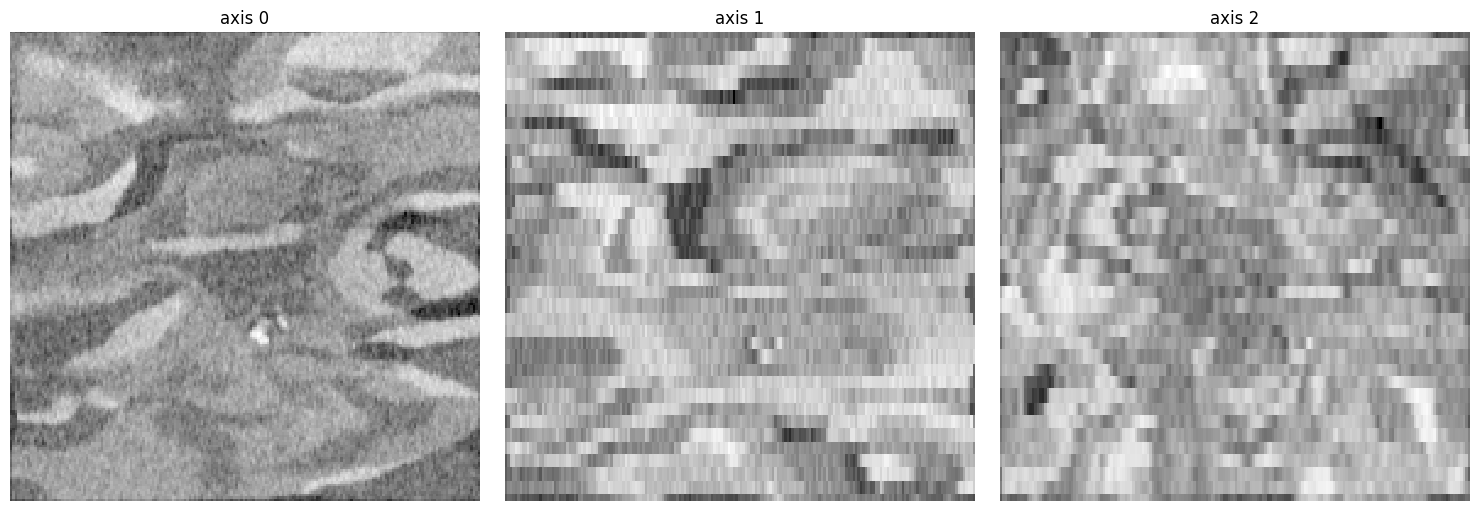

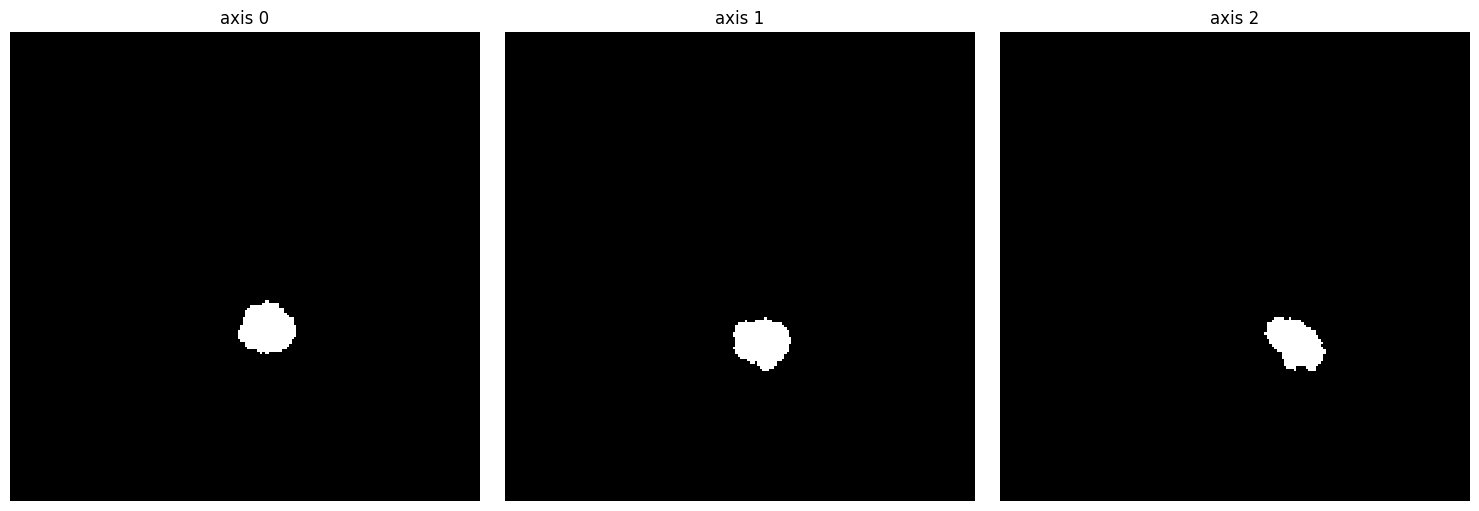

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 18104


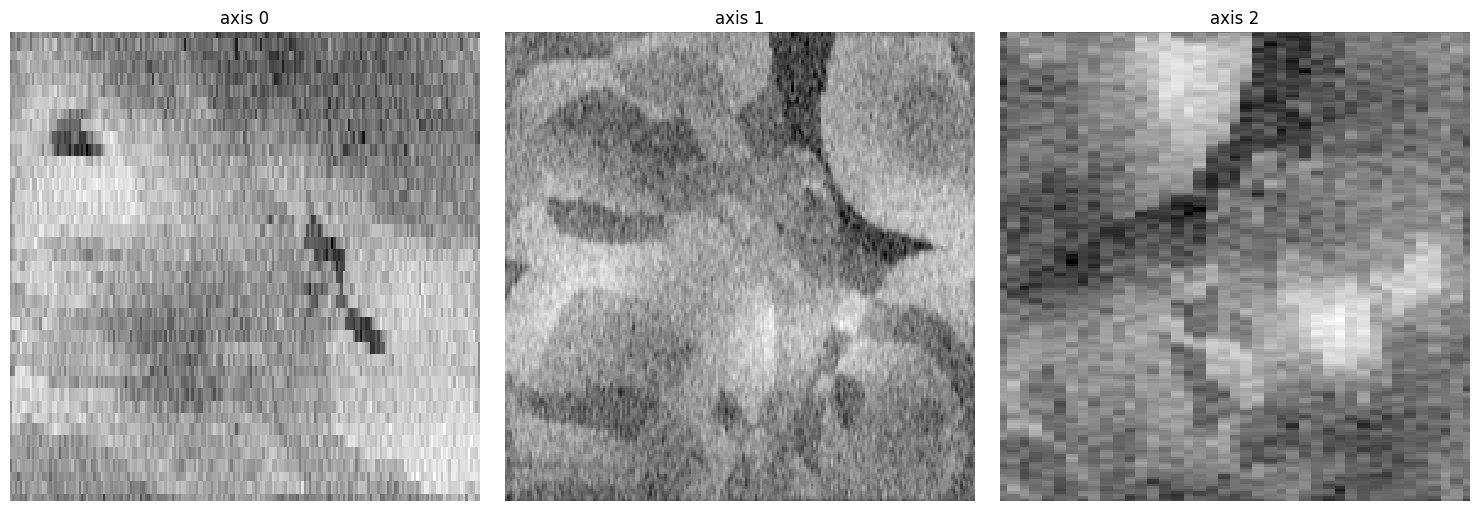

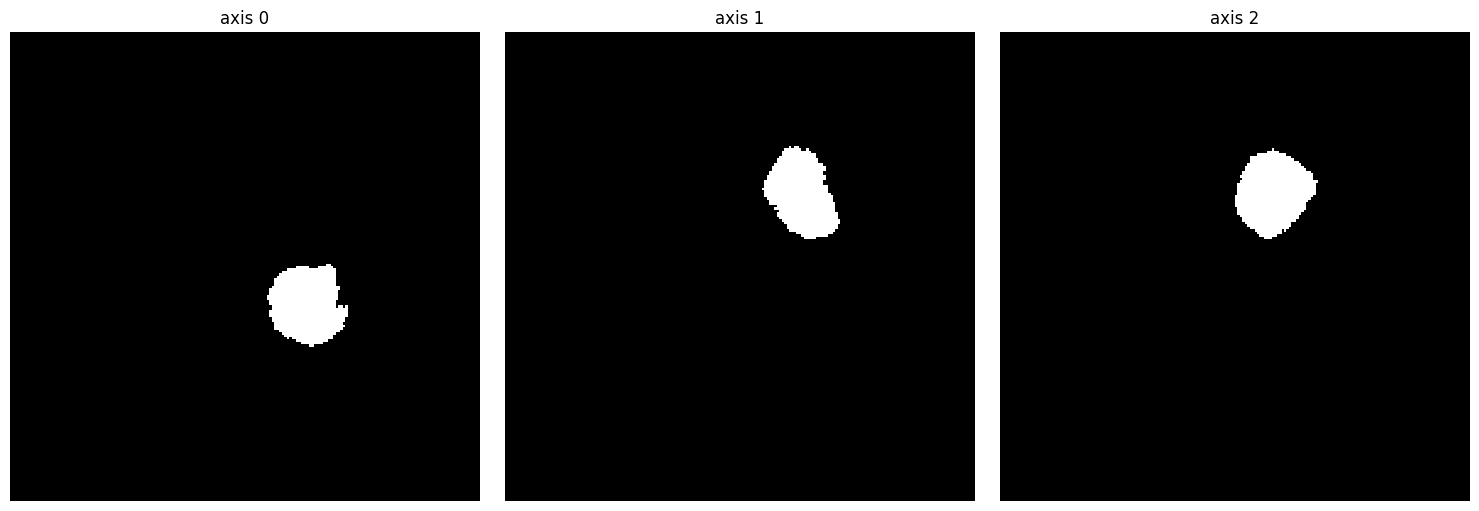

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 5282


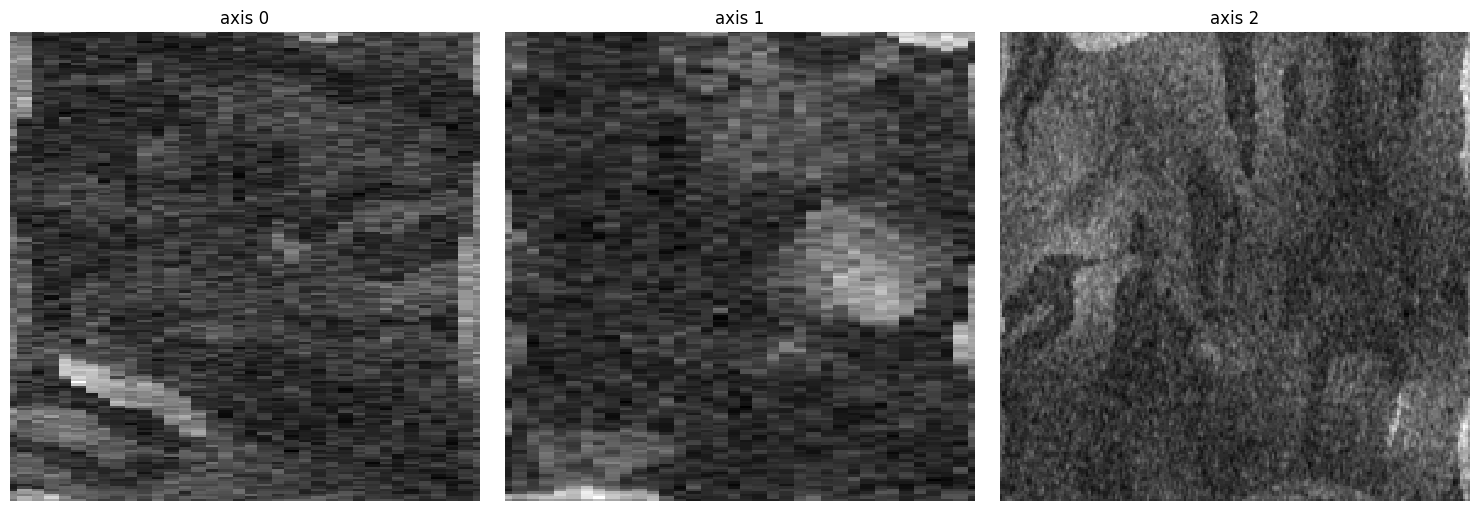

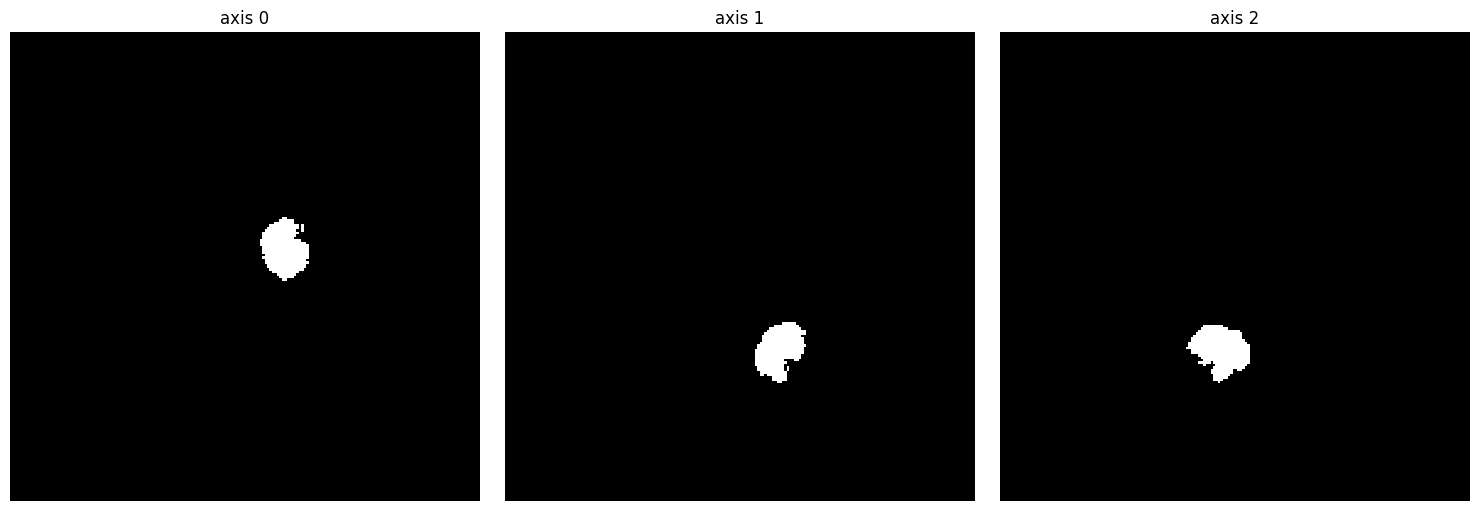

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 67910


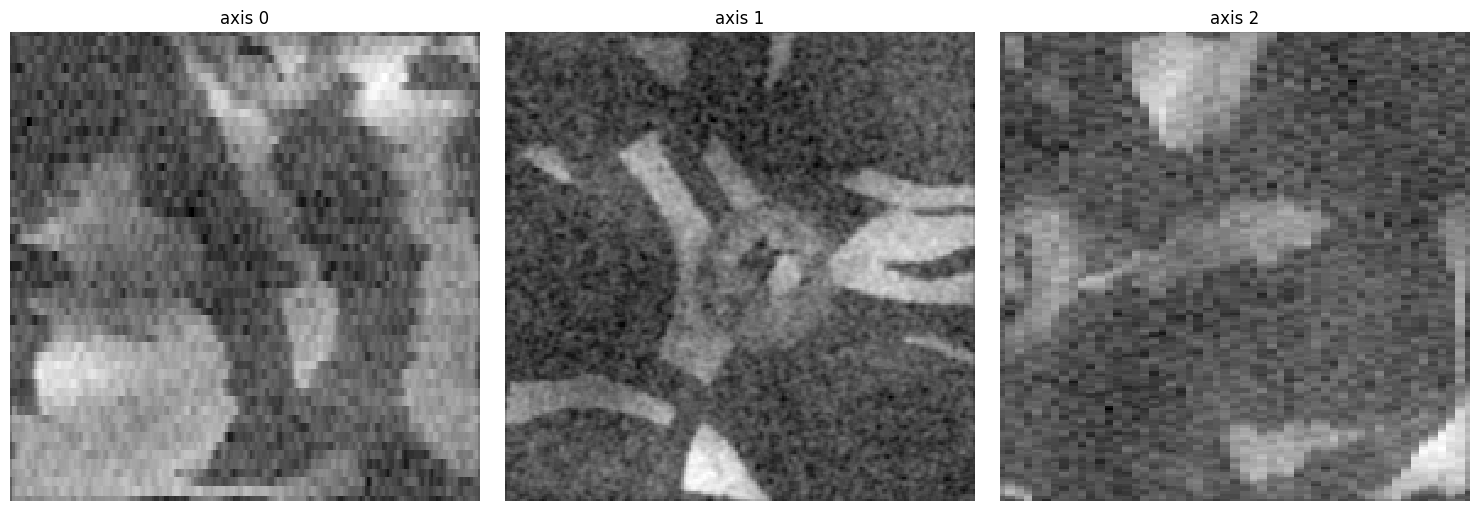

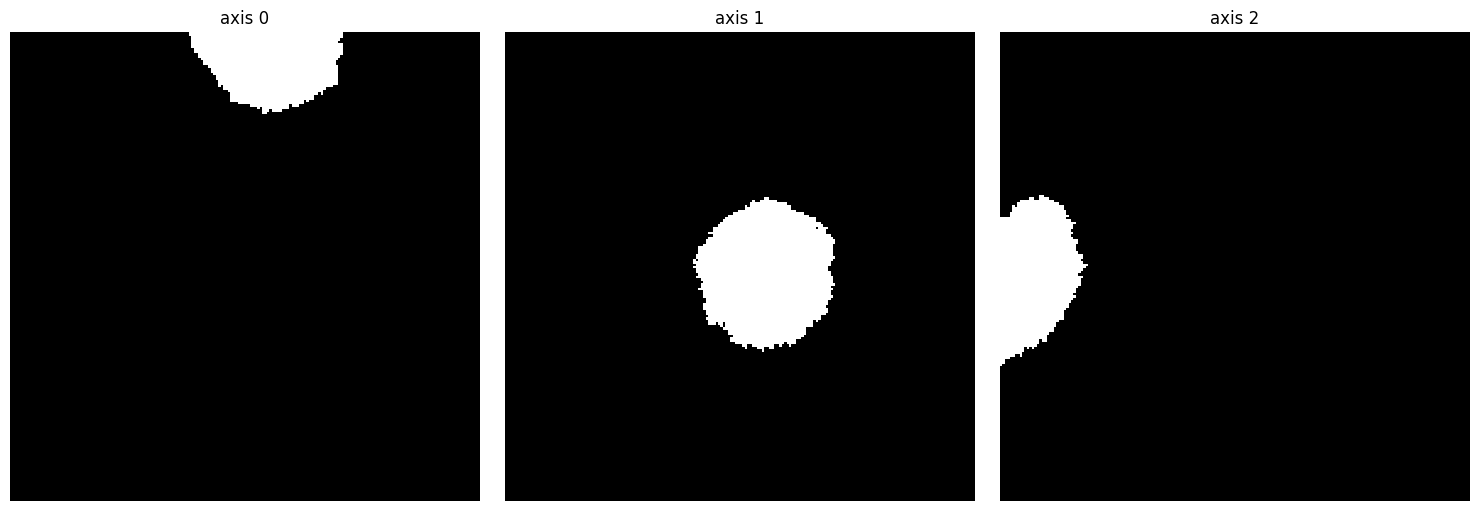

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 5282


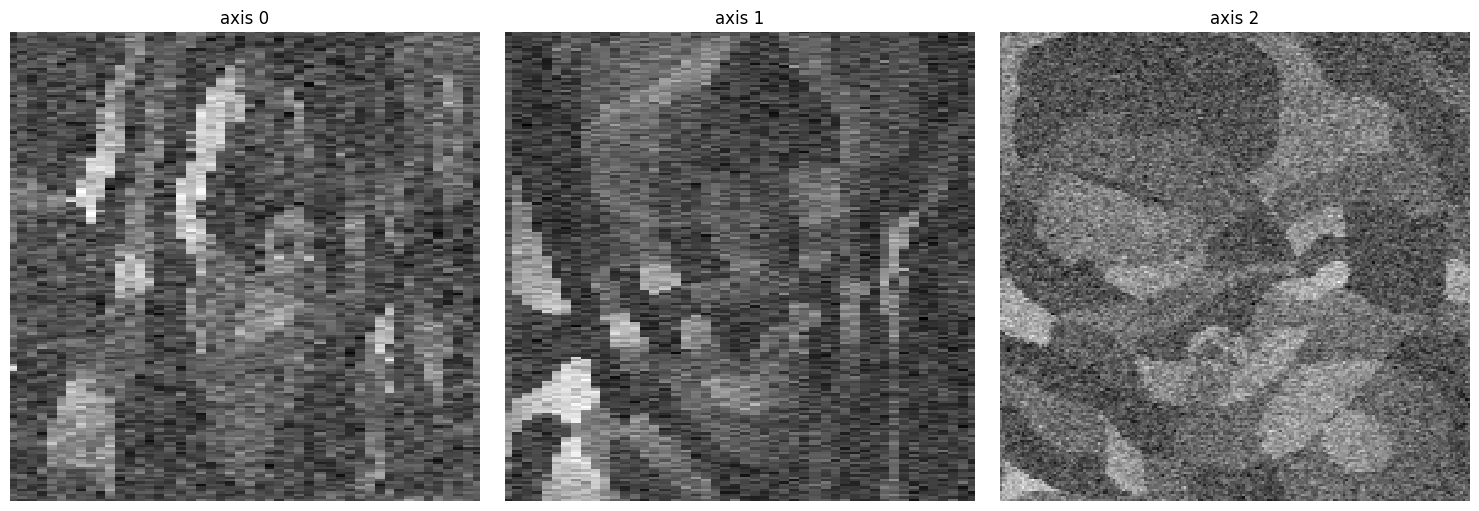

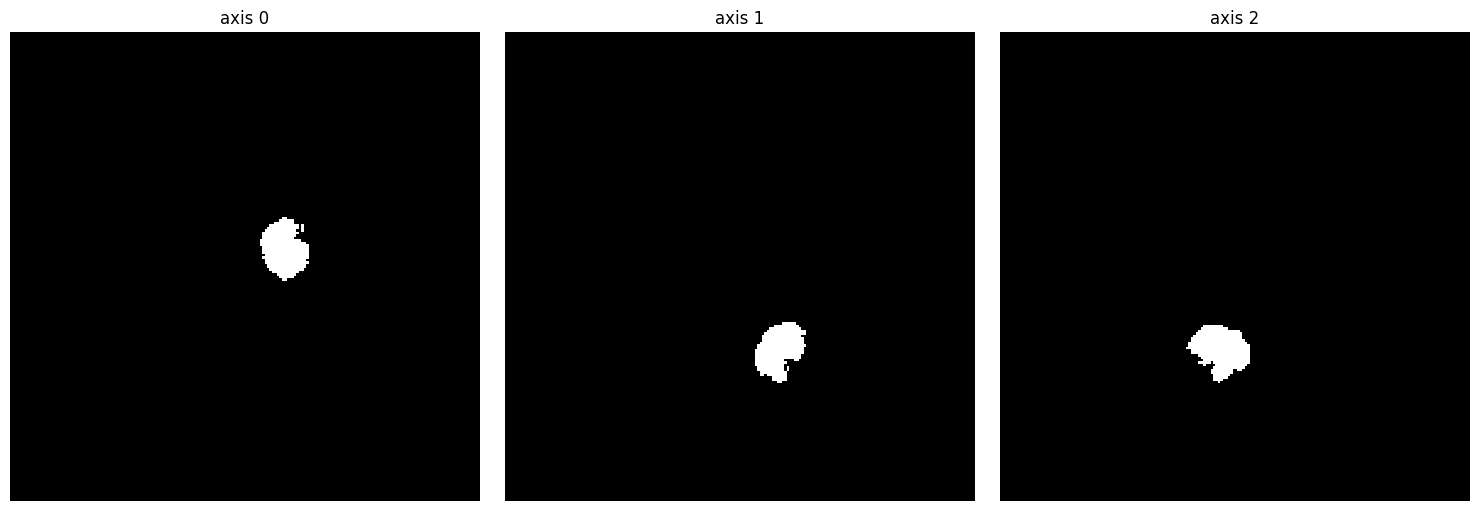

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 14829


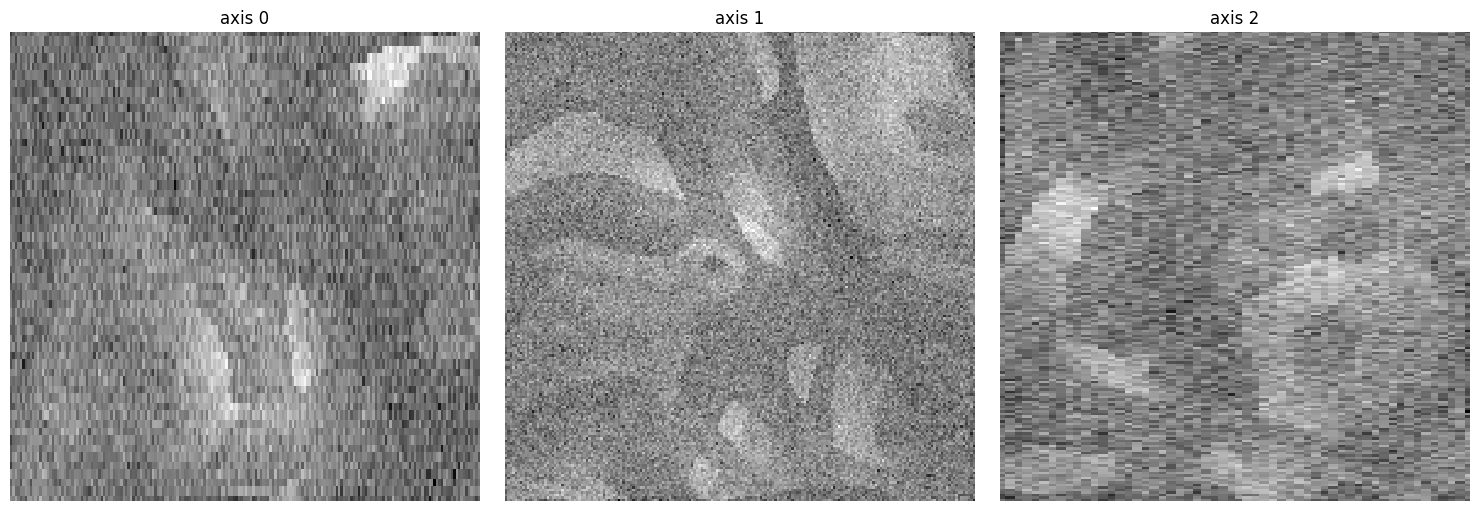

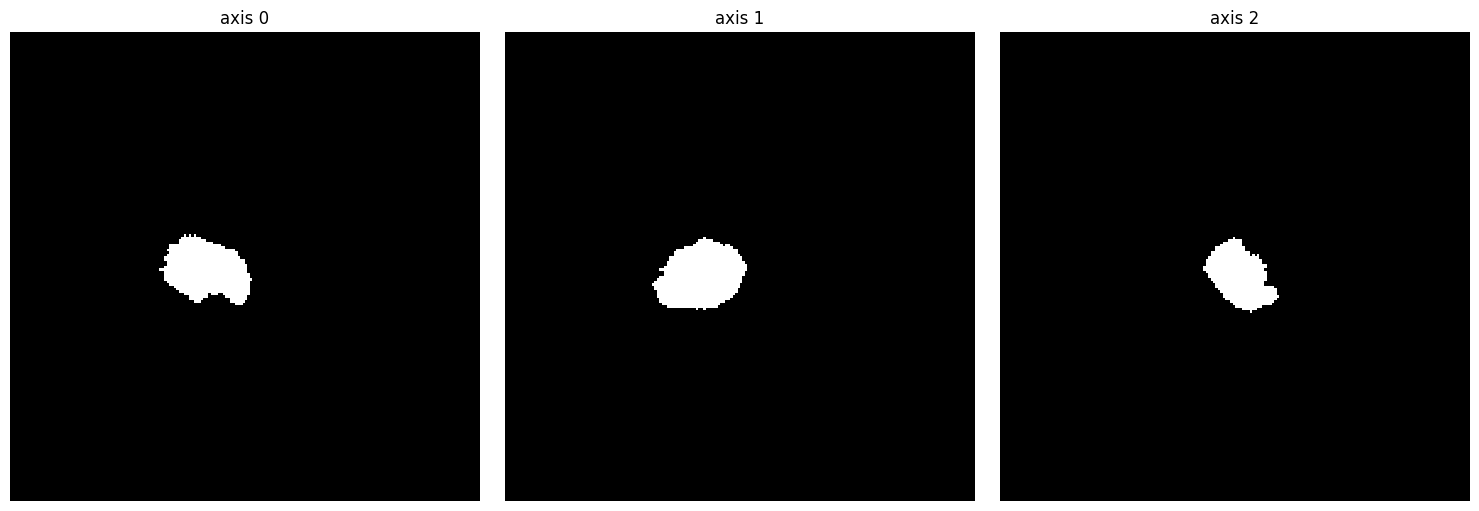

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 59791


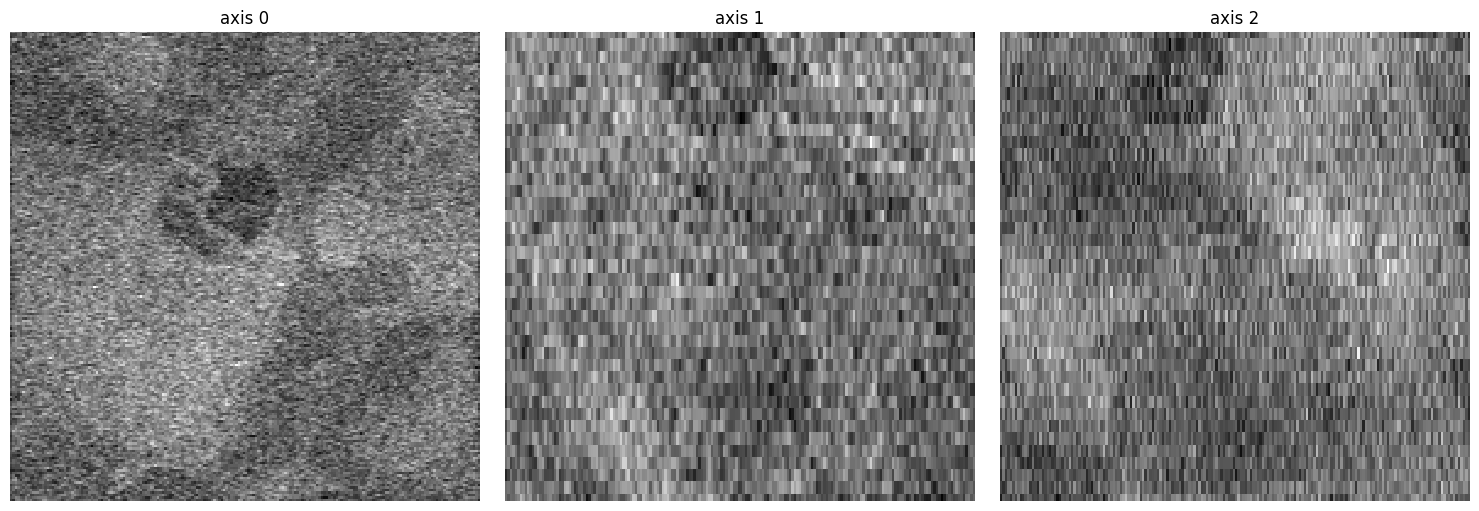

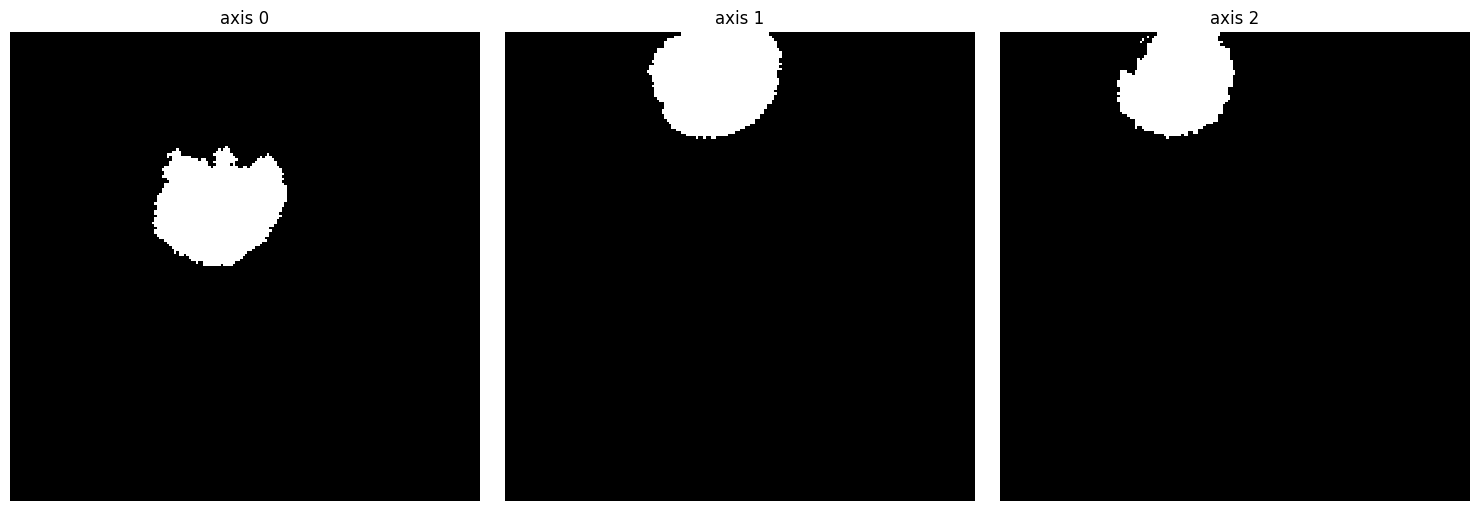

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 14829


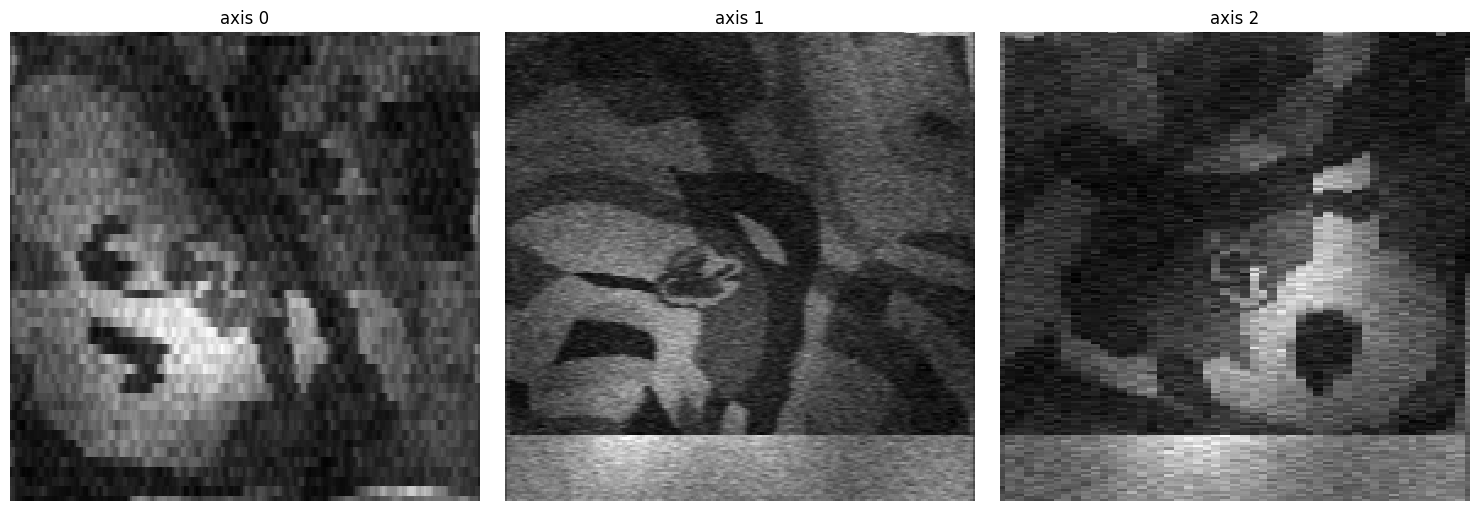

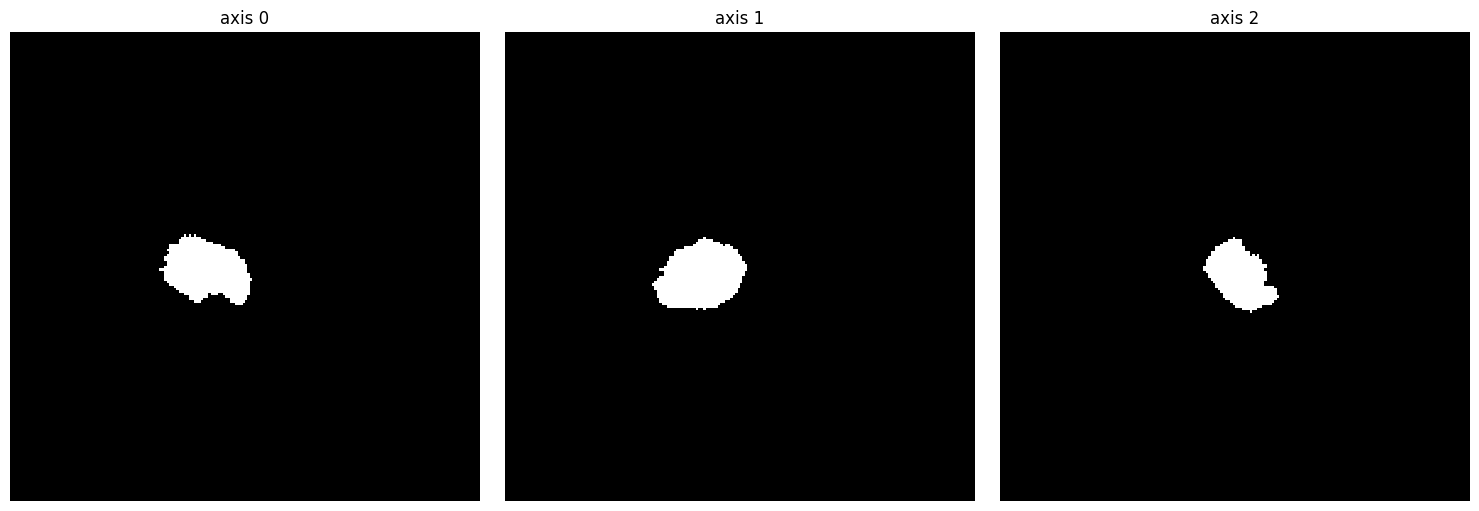

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 11549


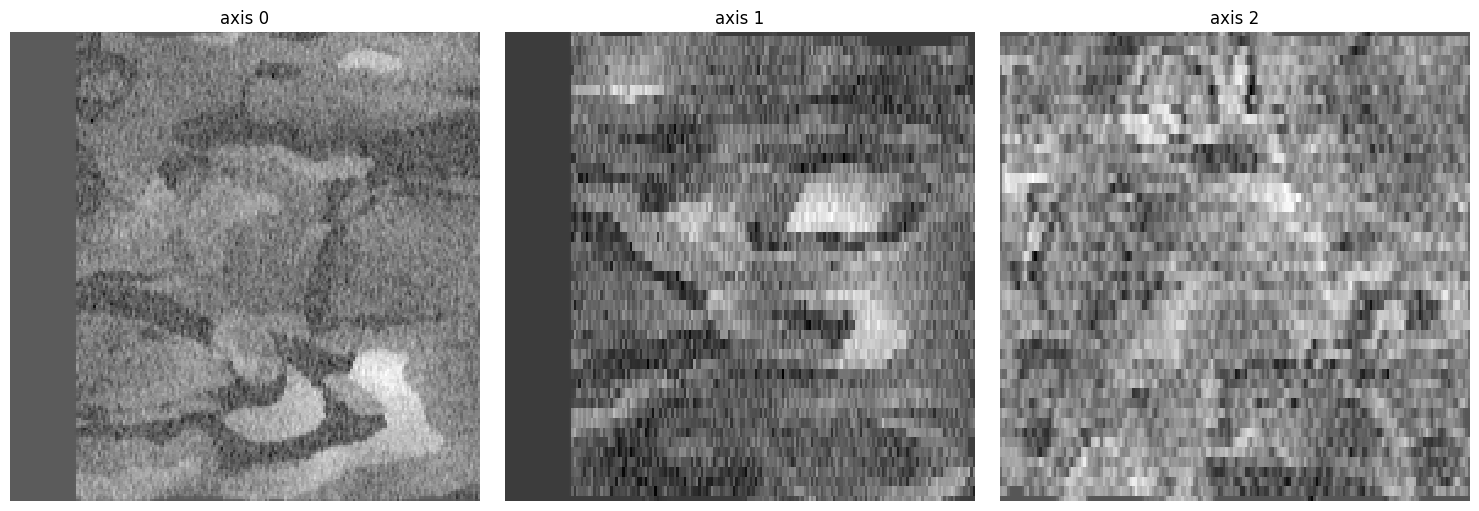

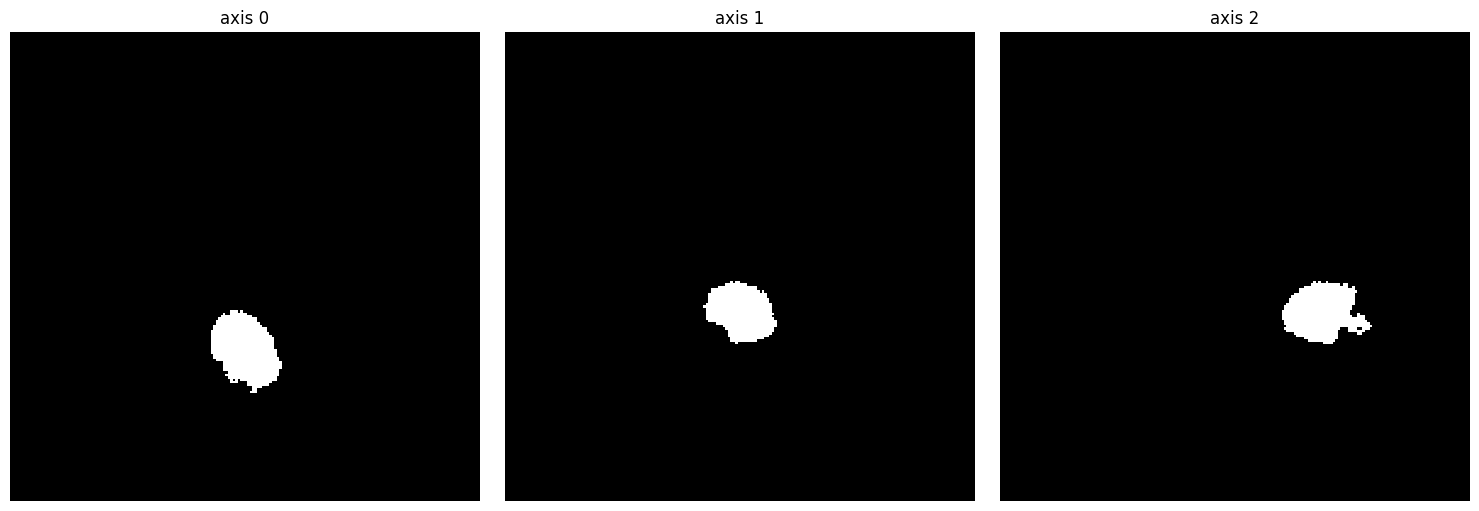

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 110002


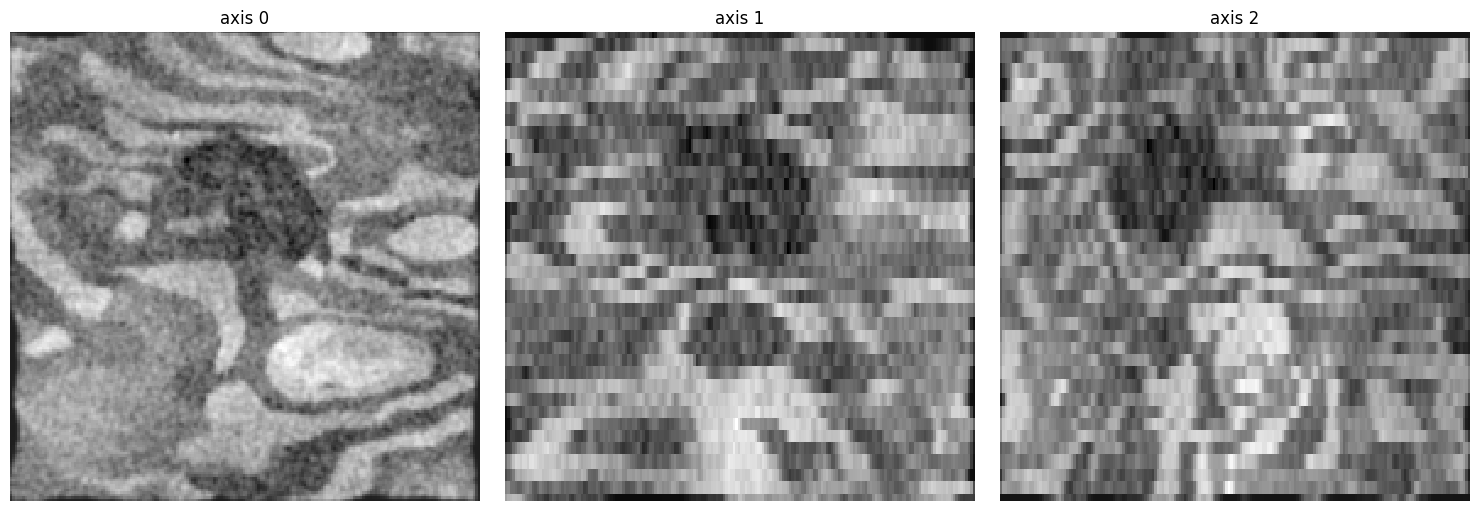

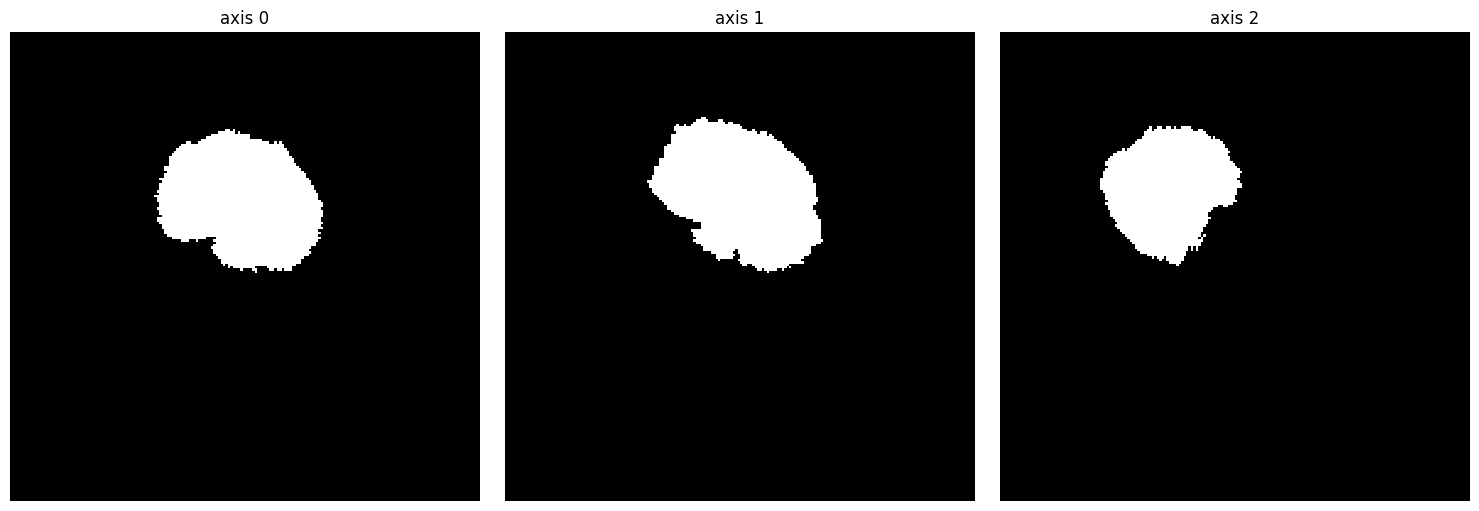

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 6737


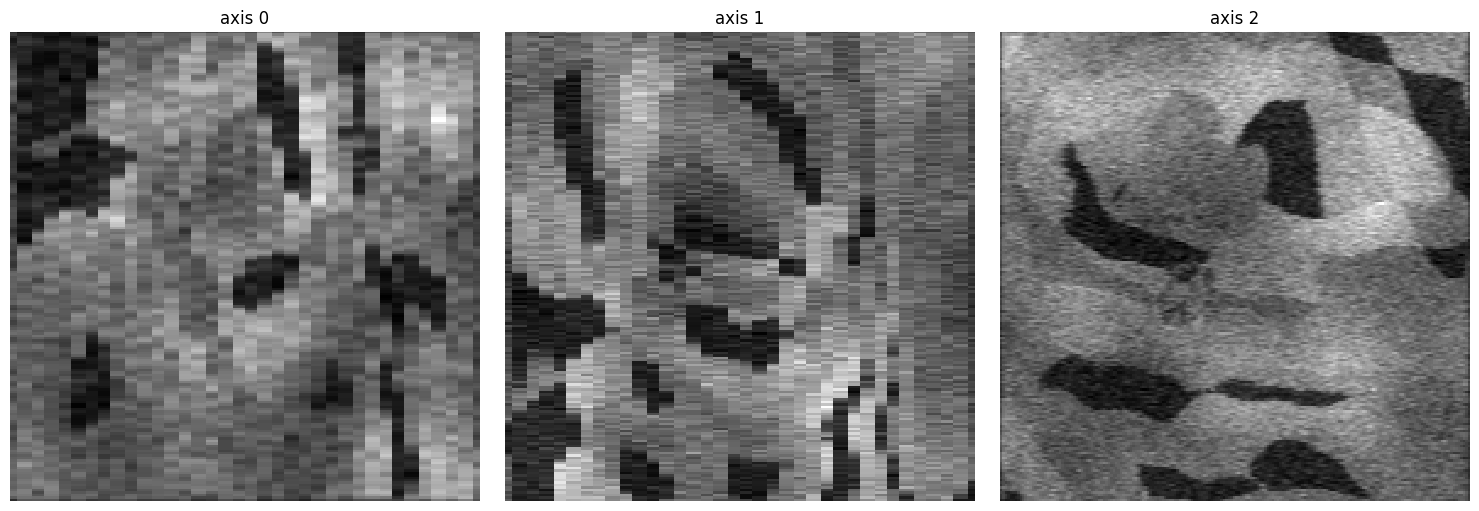

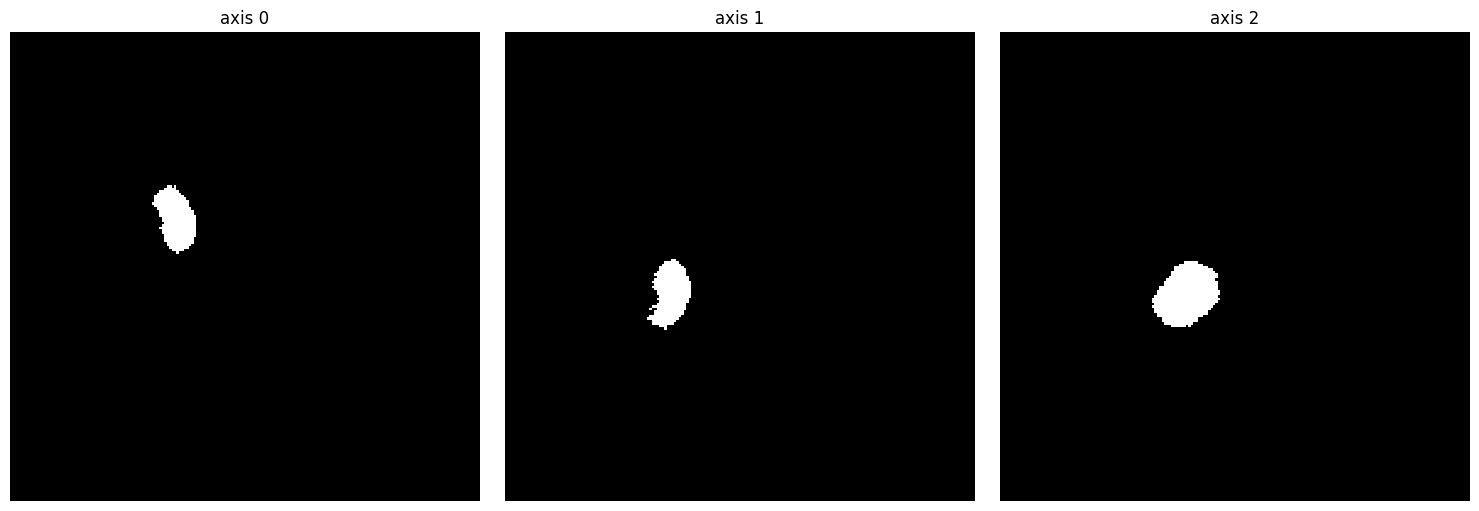

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 5888


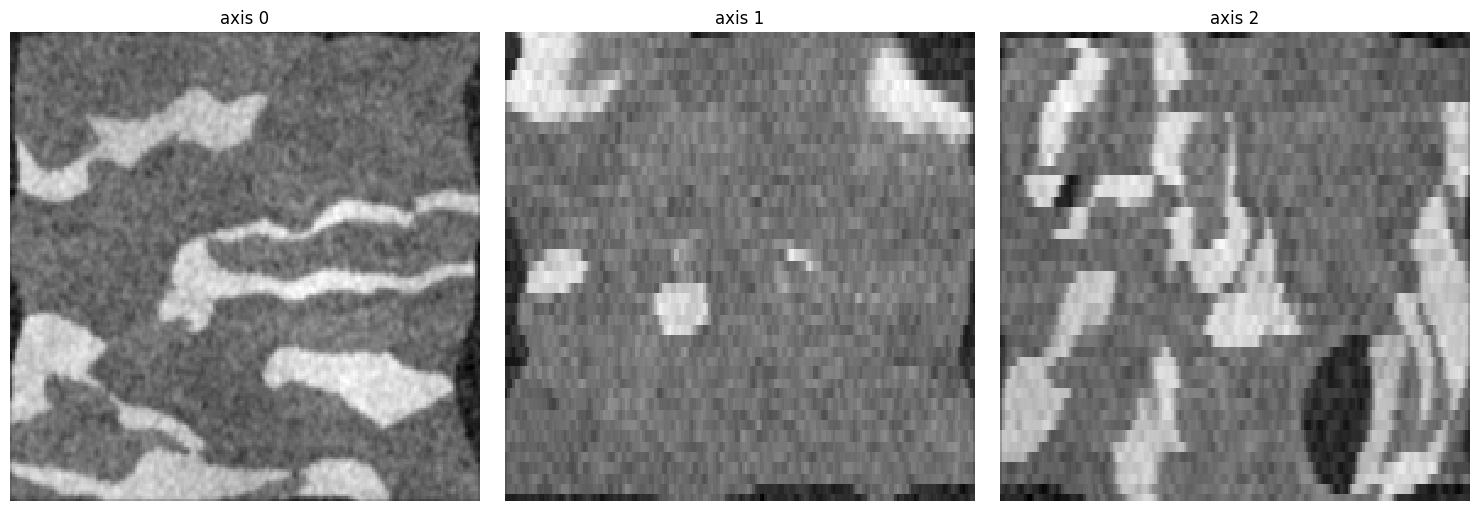

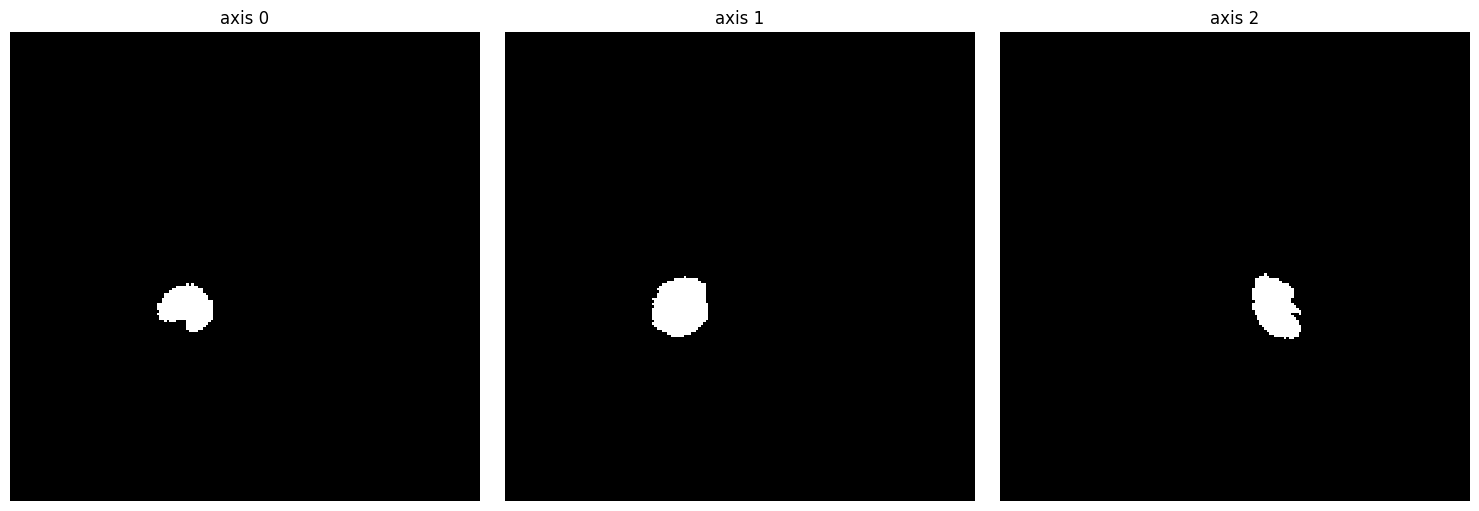

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 67910


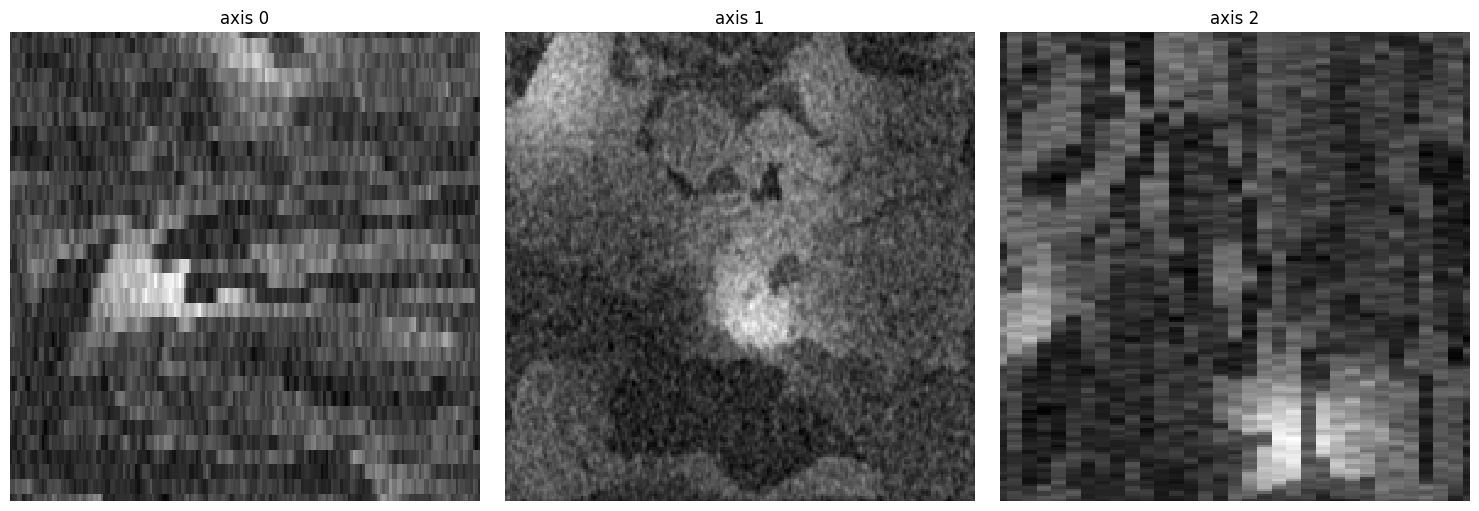

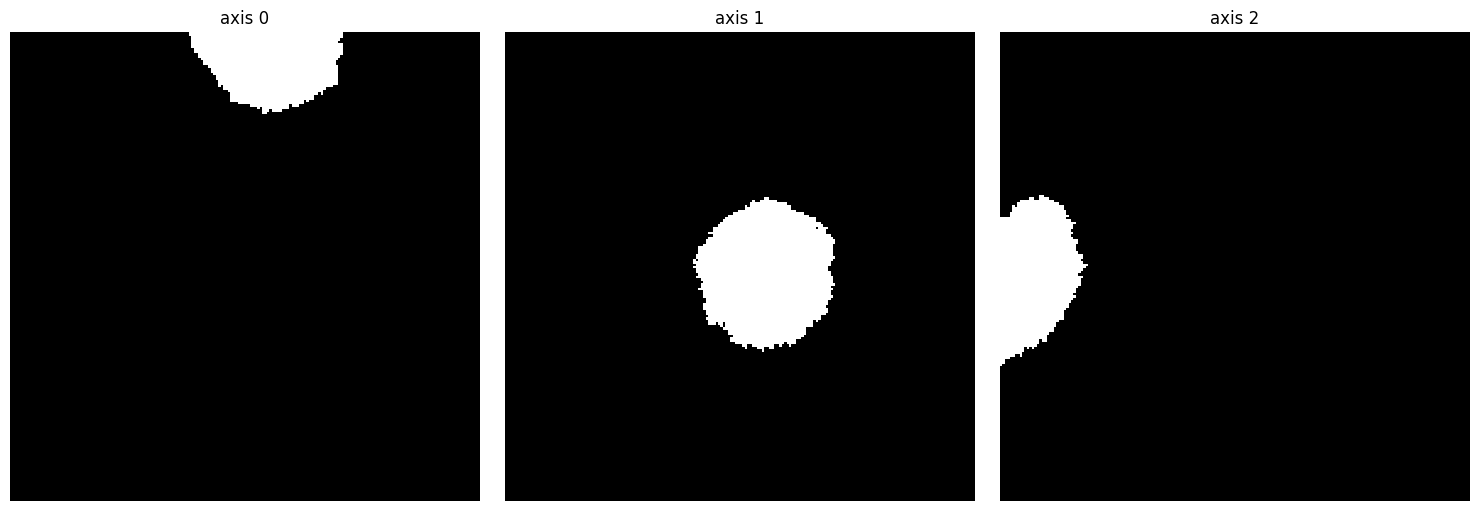

a.shape (1, 192, 192, 192, 1)
y shape (192, 192, 192) 18104


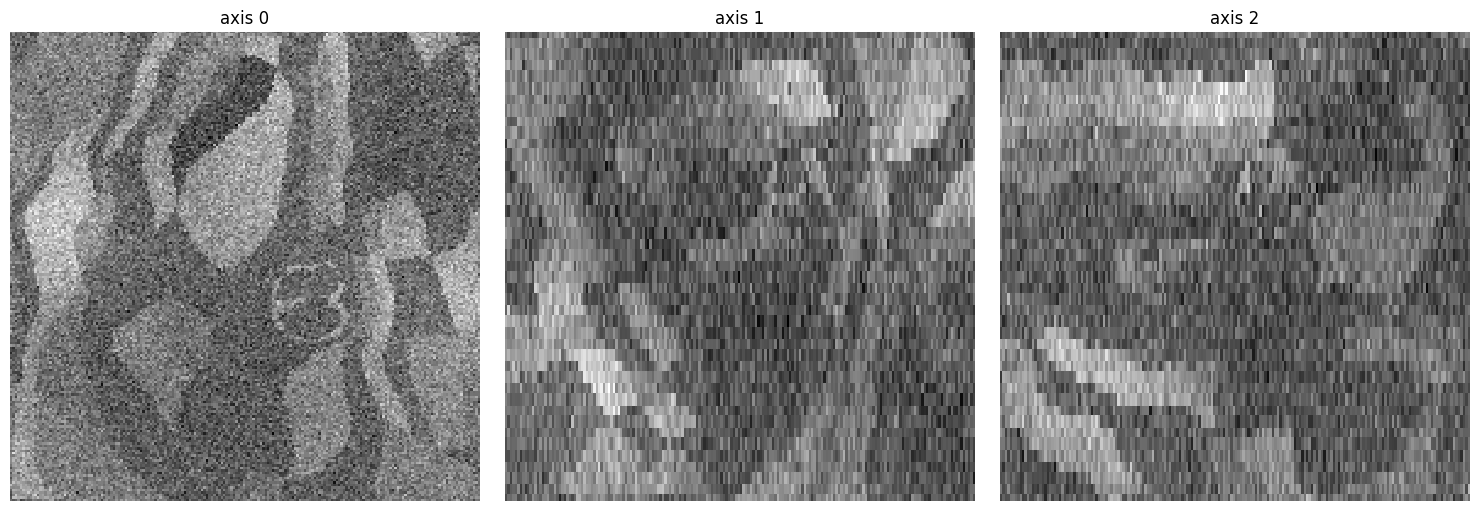

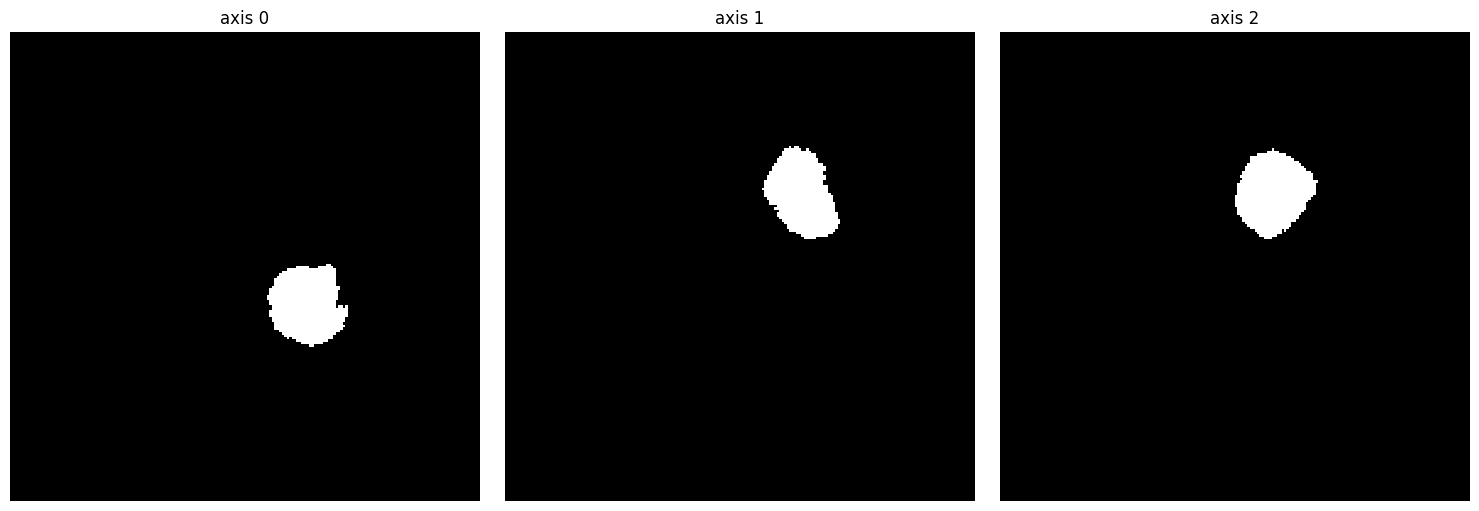

In [15]:
# print(output_brain.shape)
images = []
one_hots = []
slices_at_com = []
images_at_com = []
main_folder = "validation_synth"
import numpy as np
from scipy.ndimage import label

    
for i in range(num_gen):
    a = output_labels[i]
    print("a.shape",a.shape)
    subfolder_path = os.path.join(main_folder, f"image_{i}")

    generated_img, y = labels_to_image_model(a)
    generated_img = np.squeeze(generated_img,axis=(0,-1))
    
    # print(generated_img.shape,mask.shape)
    # mask1 = np.squeeze(np.argmax(y,axis=-1),axis=0)

    # mask = fit_bounding_rect_box(y)
    # print(y.shape)

    y = tf.argmax(y, axis=-1, output_type=tf.int32)
    y = np.squeeze(y,axis=0)

    print("y shape",y.shape,np.sum(y))

    mean_slice_numbers = tuple(np.median(indices) for indices in np.where(y != 0))

    if np.isnan(mean_slice_numbers).any():
        print("mean_slice_numbers:",mean_slice_numbers)
        continue
            
    ne.plot.volume3D(generated_img,cmaps=['gray'],slice_nos=mean_slice_numbers);
    ne.plot.volume3D(y,cmaps=['gray'],slice_nos=mean_slice_numbers);

    # print("shape after box",mask.shape)
    # mask = np.argmax(mask,axis=-1)
    # mask = np.squeeze(mask,axis=0)

    nib.save(nib.Nifti1Image(generated_img, np.eye(4)), f"{subfolder_path}/image.nii.gz")
    nib.save(nib.Nifti1Image(np.int32(y),np.eye(4)), f"{subfolder_path}/manual.nii.gz")
    # ne.plot.volume3D(mask,cmaps=['gray'])


In [43]:
y.shape

TensorShape([1, 192, 192, 192, 2])